In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
%matplotlib widget 


In [2]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [3]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    if "u/jneveu" in c and "auxtel_atmo" in c:
        print(c)

u/jneveu/auxtel_atmosphere_202301_test
u/jneveu/auxtel_atmosphere_202301_test/20231018T104932Z
u/jneveu/auxtel_atmosphere_202301_v3.0.1_doGainsPTC_rebin2
u/jneveu/auxtel_atmosphere_202301_v3.0.1_doGainsPTC_rebin2/20231010T200421Z
u/jneveu/auxtel_atmosphere_202301_v3.0.1_doGainsPTC_rebin2/20231011T203316Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2/20231015T082001Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2/20231016T150910Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2/20231018T112741Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2_testPressure
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2_testPressure/20231112T090905Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2_testPressure/20231116T135513Z
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2_testPressure_noAtmFit
u/jneveu/auxtel_atmosphere_202301_v3.0.2_doGainsPTC_rebin2_testPressure_noAt

## Check the presence of the spectra

In [112]:
where = "instrument='LATISS' and visit.day_obs=20231120" 
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [111]:
print(len(records))
records[-1]

0


IndexError: list index out of range

In [15]:
for i, r in enumerate(records):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",r.id)
    print("day_obs..................:",r.day_obs)
    print("target..................:",r.target_name)
    print("filt+disp..................:",r.physical_filter)

    # spec = butler.get('spectractorSpectrum', visit=r.id, detector=0, collections=my_collection, instrument='LATISS')
    
    if i>5:
        break

============= (0) ============datasetType = spectraction ============================================
fullId..................: 2023111500317
day_obs..................: 20231115
target..................: HD2811
filt+disp..................: empty~holo4_003
============= (1) ============datasetType = spectraction ============================================
fullId..................: 2023111500318
day_obs..................: 20231115
target..................: HD2811
filt+disp..................: empty~holo4_003
============= (2) ============datasetType = spectraction ============================================
fullId..................: 2023111500324
day_obs..................: 20231115
target..................: HD38666
filt+disp..................: empty~holo4_003
============= (3) ============datasetType = spectraction ============================================
fullId..................: 2023111500325
day_obs..................: 20231115
target..................: HD38666
filt+disp..........

In [29]:
# delete a collection
# butler.pruneDatasets(datasetRefs, disassociate=True, unstore=True, purge=True)

## Load one spectrum

In [67]:
dataId = {"day_obs": 20231115, "seq_num": 346, 'instrument':'LATISS',"detector": 0}
spec= butler.get('spectractorSpectrum',dataId,collections=my_collection)
p = butler.get('spectrumLibradtranFitParameters',dataId,collections=my_collection)
p

FitParameters(values=array([8.33620449e-01, 0.00000000e+00, 3.38364263e-02, 0.00000000e+00,
       3.33961638e+02, 2.97875643e+00, 2.08643005e+00, 1.86794011e+02,
       9.41427999e-01, 0.00000000e+00]), labels=['A1', 'A2', 'VAOD', 'angstrom_exp', 'ozone [db]', 'PWV [mm]', 'reso [pix]', 'D_CCD [mm]', 'alpha_pix [pix]', 'B'], axis_names=['$A_1$', '$A_2$', 'VAOD', '$\\"a$', 'ozone [db]', 'PWV [mm]', 'reso [pix]', '$D_{CCD}$ [mm]', '$\\alpha_{\\mathrm{pix}}$ [pix]', '$B$'], bounds=[[0, 2], [0, 20.0], [0, 0.1], [0, 3], [0.0, 600.0], [0.0, 10.0], [0.1, 10], [184.91354955079464, 188.91354955079464], [-2, 2], [-inf, inf]], fixed=[False, True, True, False, False, False, False, False, True, True], truth=None, filename='', extra=None)

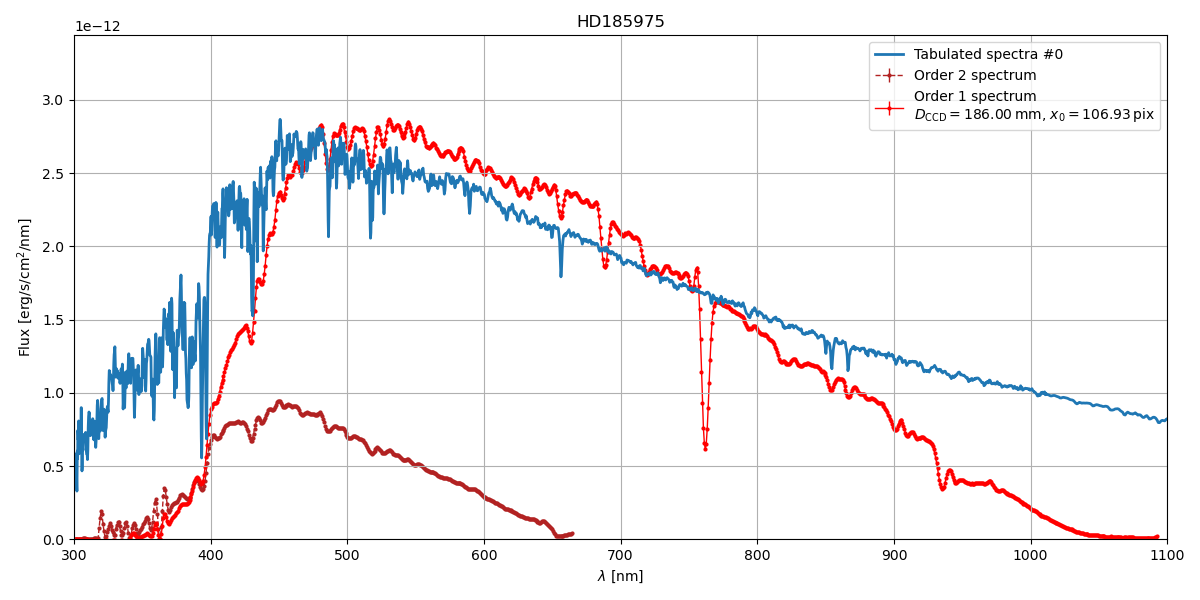

In [68]:
_ = spec.plot_spectrum()

## Load all Libradtran parameters

In [92]:
params_spectrum = []
params_spectrogram = []
times = []
headers = []
spectra = []

for i, r in enumerate(records):
    try:
        times.append(r.day_obs)
        spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        headers.append(spec.header)
        spectra.append(spec)
        p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrum.append(p)
        p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrogram.append(p)
    except ValueError:
        print("Skip", r.id)
        continue

In [93]:
len(params_spectrogram)

48

In [94]:
def select_files(collection, where):
    # datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where=where)
    #records = list(butler.registry.queryDimensionRecords('exposure', where=where))
    records = list(butler.registry.queryDimensionRecords('exposure', datasets='spectractorSpectrum', where=where,  collections=collection))
    records = sorted(records, key=lambda x: x.id, reverse=False)
    return records

def filter_data(records, sigma_clip=3):  # pragma: no cover
    from scipy.stats import median_abs_deviation
    D = []
    chi2 = []
    dx = []
    amplitude = []
    regs = []
    times = []
    specs = []
    alpha_0_2 = []
    #parameters.VERBOSE = False
    #parameters.DEBUG = False
    for i, r in enumerate(records):
        times.append(r.day_obs)
        spec = butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        spec.dataId = r.id
        if spec.x0[0] > 500: 
            continue
        D.append(spec.header["D2CCD"])
        dx.append(spec.header["PIXSHIFT"])
        regs.append(np.log10(spec.header["PSF_REG"]))
        amplitude.append(np.sum(np.abs(spec.data[300:])))
        # if "CHI2_FIT" in header:
        chi2.append(spec.header["CHI2_FIT"])
        specs.append(spec)
        p = butler.get('spectrumForwardModelFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        alpha_0_2.append(p.values[p.get_index("alpha_0_2")])
        #except:
        #    new_file_names.remove(name)
        #    print(f"fail to open {name}. len(file_names)={len(new_file_names)}")
    params = {'D2CCD': np.array(D),
              'dx': np.array(dx),
              'regs': np.array(regs),
              'chi2': np.array(chi2),
              'amplitude': np.array(amplitude),
              'alpha_0_2': np.array(alpha_0_2)
             }
    k = np.arange(len(D))
    filter_indices = np.ones_like(k, dtype=bool)
    for par in params.keys():
        if par in ['amplitude']: #, 'alpha_0_2']:
            continue
        filter_indices *= np.logical_and(params[par] > np.median(params[par]) - sigma_clip * median_abs_deviation(params[par]),
                                         params[par] < np.median(params[par]) + sigma_clip * median_abs_deviation(params[par]))
    for par in params.keys():
        fig = plt.figure()
        plt.plot(k, params[par])
        plt.plot(k[filter_indices], params[par][filter_indices], "ko")
        plt.grid()
        plt.title(par)
        plt.show()
    return [s for i,s in enumerate(specs) if filter_indices[i]]


def plot_spectra(spectra, colorparams):

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


    fig  = plt.figure(figsize=(7,3))
    for spec in spectra:
        plt.plot(spec.lambdas, spec.data, color = colormap(normalize(spec.airmass)))
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    plt.ylabel(f"Flux [{spec.units}]")
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    plt.show()
    return fig



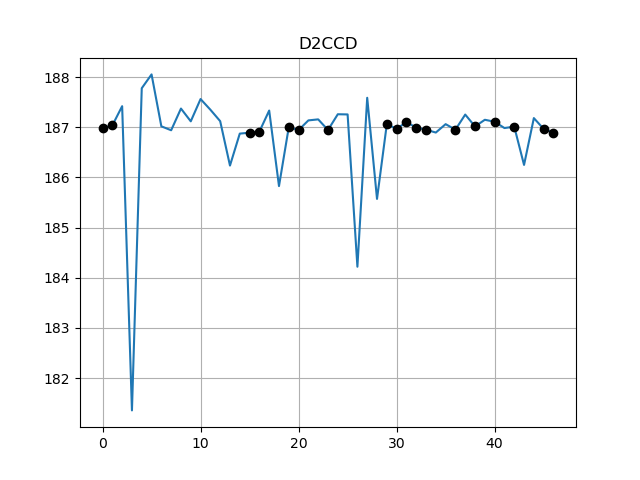

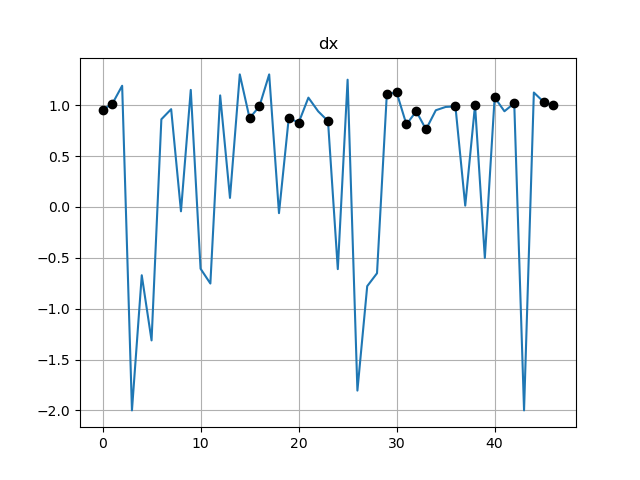

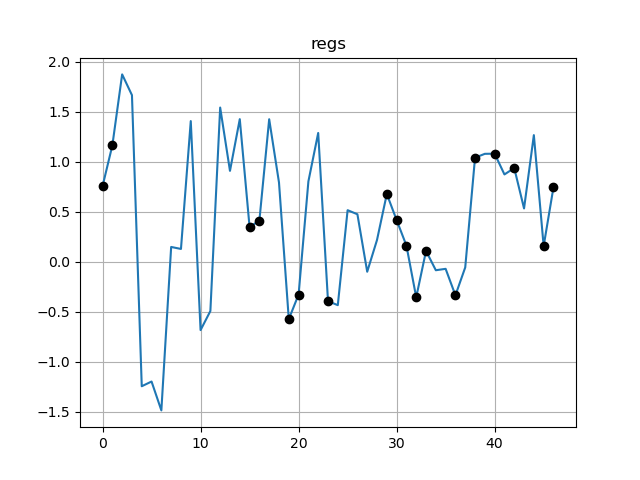

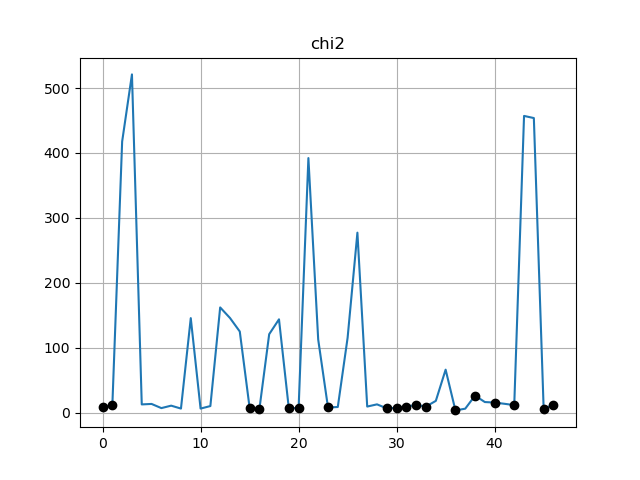

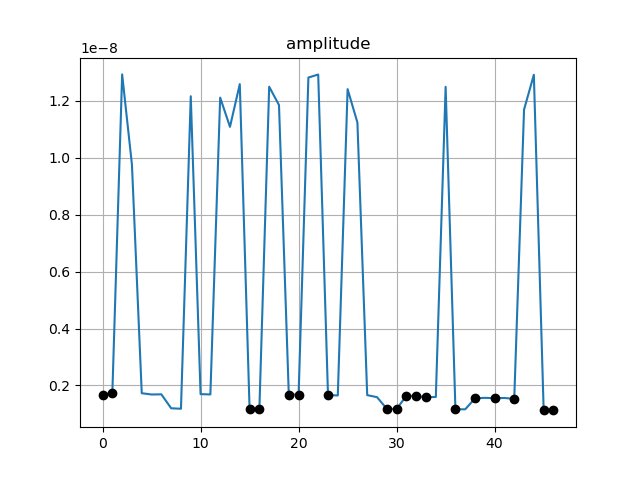

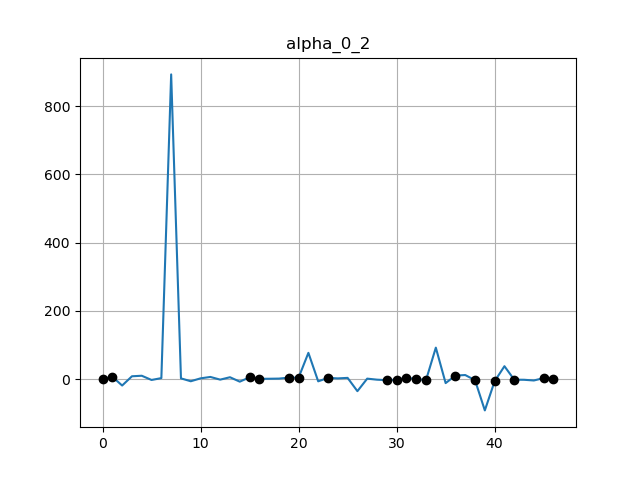

In [95]:
spectra_filtered = filter_data(records)

/tmp/ipykernel_45847/657744519.py:88: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


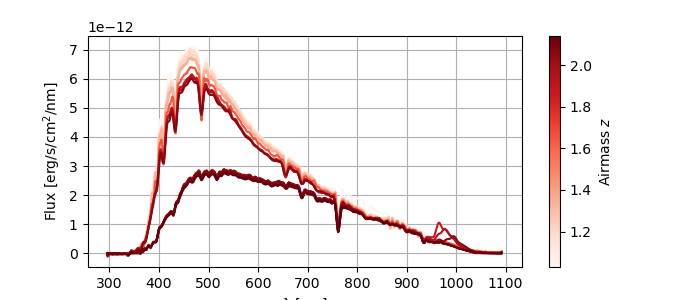

In [102]:
fig = plot_spectra(spectra_filtered, [spec.airmass for spec in spectra_filtered])

In [103]:
np.unique([spec.target.label for spec in spectra_filtered])

array(['HD185975', 'HD2811'], dtype='<U8')

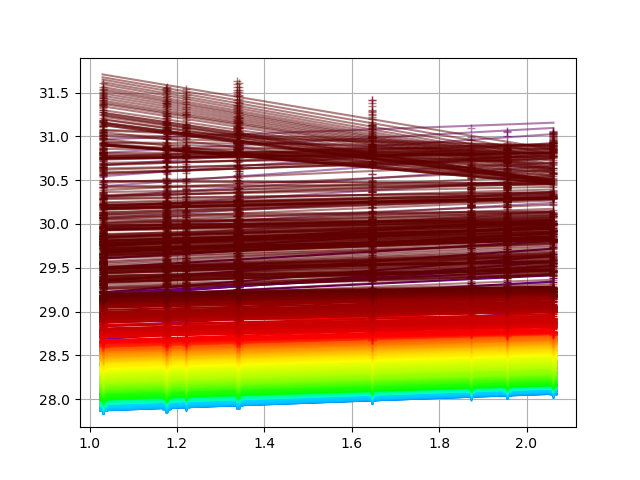

In [107]:
target_label = 'HD2811'
wls = np.arange(370, 1000, 1)
cmap = from_lambda_to_colormap(lambdas)
pvals = []

fig = plt.figure()
for wl in wls:
    zs = [spec.airmass for spec in spectra_filtered if spec.target.label == target_label]
    mag = -2.5*np.log10([np.interp(wl, spec.lambdas, spec.data) for spec in spectra_filtered if spec.target.label == target_label])
    regr = np.polyfit(zs, mag, deg=1)
    pvals.append(regr)
    p = plt.plot(zs, mag, '+', label=wl, color=wavelength_to_rgb(wl))
    plt.plot(zs, np.polyval(regr, zs), color=p[0].get_color())
plt.grid()
#plt.legend()
plt.show()

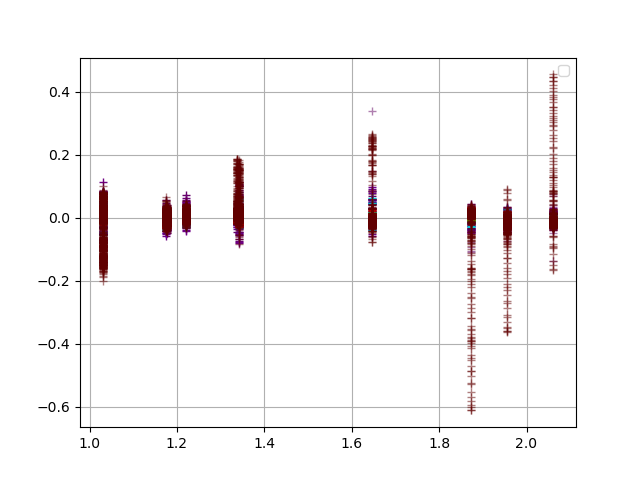

In [108]:
fig = plt.figure()
for wl in wls:
    zs = [spec.airmass for spec in spectra_filtered if spec.target.label == target_label]
    mag = -2.5*np.log10([np.interp(wl, spec.lambdas, spec.data) for spec in spectra_filtered if spec.target.label == target_label])
    regr = np.polyfit(zs, mag, deg=1)
    plt.plot(zs, mag - np.polyval(regr, zs), '+', color=wavelength_to_rgb(wl))
plt.grid()
plt.legend()
plt.show()

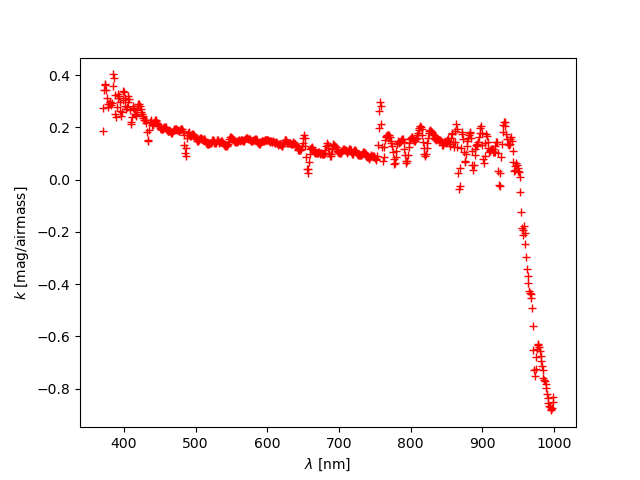

In [109]:
fig = plt.figure()
plt.plot(wls, [p[0] for p in pvals], "r+")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("$k$ [mag/airmass]")
plt.show()

In [113]:
import matplotlib
matplotlib.pyplot.close()

In [114]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [115]:
min_index = 0
max_index = np.inf

df1 = pd.DataFrame(columns=columns_spectrum)

for k, header in enumerate(headers):
    # if k > 40: break
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for h in header:
        if h in columns_spectrum:
            row[h] = header[h]
    df1.loc[len(df1)] = row
            
df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)

for k, p in enumerate(params_spectrogram):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df2.loc[len(df2)] = row
            
df3 = pd.DataFrame(columns=columns_spectrum_bestfit)

for k, p in enumerate(params_spectrum):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df3.loc[len(df3)] = row
            


/home/j/jneveu/repos/SpectractorDESC/lib/python/spectractor/fit/fitter.py:311: RuntimeWarning: invalid value encountered in sqrt
  err[~np.asarray(self.fixed)] = np.sqrt(np.diag(self.cov))


In [116]:
df3

A1        A1_err   A2  A2_err      VAOD       VAOD_err  \
0   0.890919  8.249058e-04  0.0     0.0  0.100000       0.000000   
1   0.878301  4.939558e-03  0.0     0.0  0.031409       0.008557   
2   1.462333  4.570030e+01  0.0     0.0  0.065421      13.828945   
3   1.016348  5.558787e-03  0.0     0.0  0.100000       0.000000   
4   0.911984  4.113795e-03  0.0     0.0  0.100000       0.005375   
5   0.884068  1.157730e-01  0.0     0.0  0.100000       0.126969   
6   0.906506  1.167818e-01  0.0     0.0  0.100000       0.122916   
7   0.943877  7.701064e-04  0.0     0.0  0.093729       0.000000   
8   0.799145  7.159457e-04  0.0     0.0  0.010639       0.000522   
9   1.047012  2.880465e-01  0.0     0.0  0.012797       0.338288   
10  0.912103  1.328332e-01  0.0     0.0  0.100000       0.133687   
11  0.821844  1.787345e-03  0.0     0.0  0.025075       0.002923   
12  1.095951  2.869798e+01  0.0     0.0  0.074332      16.811106   
13  1.038044  4.304993e-01  0.0     0.0  0.038697       0.324636   
14  1.257673  1.448586e+00  0.0     0.0  0.071212       0.888981   
15  0.782834  2.079752e-03  0.0     0.0  0.000496       0.001593   
16  0.899990  7.732965e-04  0.0     0.0  0.065884       0.000000   
17  1.104231  1.185350e+00  0.0     0.0  0.061963       0.876382   
18  1.276218  1.285673e+03  0.0     0.0  0.100000     793.288125   
19  0.911071  7.542315e-04  0.0     0.0  0.100000       0.000000   
20  0.910371  7.875835e-04  0.0     0.0  0.100000       0.000000   
21  1.328531           NaN  0.0     0.0  0.085177  527966.487927   
22  1.210084  9.381533e+05  0.0     0.0  0.039093  726652.313570   
23  0.922339  2.824340e-01  0.0     0.0  0.100000       0.251227   
24  0.893564  8.754047e-02  0.0     0.0  0.100000       0.080583   
25  1.009186  1.422649e+00  0.0     0.0  0.099904       1.253969   
26  1.350915  9.060444e+00  0.0     0.0  0.061913       6.560955   
27  0.846161  1.680137e-02  0.0     0.0  0.049863       0.016320   
28  0.964322  5.980902e-01  0.0     0.0  0.100000       0.489253   
29  0.883661  7.174778e-04  0.0     0.0  0.057340       0.000000   
30  0.799504  7.515751e-04  0.0     0.0  0.009607       0.000529   
31  0.879249  7.940734e-04  0.0     0.0  0.074179       0.000000   
32  0.911963  7.729668e-04  0.0     0.0  0.100000       0.000000   
33  0.949728  1.366227e-01  0.0     0.0  0.100000       0.087742   
34  0.780619  1.345928e-03  0.0     0.0  0.000000       0.001285   
35  2.000000  8.912351e+15  0.0     0.0  0.000000       0.000000   
36  1.036164  6.577846e+00  0.0     0.0  0.098769       6.273455   
37  0.778012  7.071725e-04  0.0     0.0  0.000000       0.000512   
38  0.777341  7.109550e-04  0.0     0.0  0.000000       0.000507   
39  0.991480  9.403846e-01  0.0     0.0  0.100000       0.509661   
40  0.999972  4.632526e-01  0.0     0.0  0.099995       0.249487   
41  0.994268  7.158294e-01  0.0     0.0  0.100000       0.370913   
42  0.988161  7.184828e-01  0.0     0.0  0.081690       0.360164   
43  0.977034  1.282217e+00  0.0     0.0  0.099879       0.637492   
44  1.381868  3.958442e-03  0.0     0.0  0.000000       0.000000   
45  1.214640  1.889712e-01  0.0     0.0  0.100000       0.000000   
46  0.824008  6.849170e-04  0.0     0.0  0.029916       0.000000   
47  0.856880  7.367165e-04  0.0     0.0  0.052706       0.000000   

    angstrom_exp  angstrom_exp_err  ozone [db]  ozone [db]_err   PWV [mm]  \
0       0.197980      2.452847e-02  416.081762    1.157556e+01   2.555995   
1       2.793426      8.245374e-01  600.000000    8.200381e+01   2.772327   
2       0.636546      2.439662e+02  410.157210    2.233619e+04   4.922910   
3       1.897798      1.420676e-01  534.754994    3.663771e+02   0.000000   
4       2.095950      1.403418e-01  600.000000    1.547159e+01   2.583630   
5       0.392541      5.342227e-01  282.051033    1.526711e+01   2.291344   
6       0.395299      5.210175e-01  381.246938    1.501395e+01   4.867351   
7       0.342407      1.292327e-02  324.771104    5.821670e+0

In [122]:
df = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df, df3, left_index=True, right_index=True)
df.set_index('DATE-OBS', inplace=True)
df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
df.sort_index(inplace=True)
df

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2023-11-21 01:37:13.904502514+00:00  2023112000082     -64      2    1137   
2023-11-21 01:38:26.888507769+00:00  2023112000083     -64      2    1137   
2023-11-21 01:46:31.731505173+00:00  2023112000089     -64      2    1136   
2023-11-21 01:47:44.749509211+00:00  2023112000090     -64      2    1137   
2023-11-21 01:55:44.517499862+00:00  2023112000096     -64      2    1136   
2023-11-21 01:56:57.555001551+00:00  2023112000097     -64      2    1136   
2023-11-21 02:21:47.265009693+00:00  2023112000107     -64      2    1136   
2023-11-21 02:29:54.579500502+00:00  2023112000113     -64      2    1137   
2023-11-21 02:31:07.594504539+00:00  2023112000114     -64      2    1136   
2023-11-21 02:40:26.383508619+00:00  2023112000121     -64      2    1136   
2023-11-21 02:58:00.614007583+00:00  2023112000142     -64      2    1137   
2023-11-21 02:59:13.645006074+00:00  2023112000143     -64      2    1137   
2023-11-21 03:07:27.168509211+00:00  2023112000149     -64      2    1137   
2023-11-21 03:15:43.052495965+00:00  2023112000156     -64      2    1136   
2023-11-21 03:16:56.020506200+00:00  2023112000157     -64      2    1136   
2023-11-21 03:24:45.101990715+00:00  2023112000163     -64      2    1136   
2023-11-21 03:25:58.157990338+00:00  2023112000164     -64      2    1136   
2023-11-21 03:33:47.769496061+00:00  2023112000170     -64      2    1137   
2023-11-21 03:35:00.690496139+00:00  2023112000171     -64      2    1136   
2023-11-21 03:42:49.377001573+00:00  2023112000176     -64      2    1136   
2023-11-21 03:44:02.306496389+00:00  2023112000177     -64      2    1137   
2023-11-21 03:52:17.713495123+00:00  2023112000183     -64      2    1137   
2023-11-21 03:53:30.741008185+00:00  2023112000184     -64      2    1137   
2023-11-21 04:01:25.212506067+00:00  2023112000189     -64      2    1137   
2023-11-21 04:02:38.135500599+00:00  2023112000190     -64      2    1136   
2023-11-21 04:10:52.268005306+00:00  2023112000196     -64      2    1137   
2023-11-21 04:12:05.300004080+00:00  2023112000197     -64      2    1137   
2023-11-21 04:19:45.784997631+00:00  2023112000202     -64      2    1137   
2023-11-21 04:20:58.797504016+00:00  2023112000203     -64      2    1137   
2023-11-21 04:29:19.479006047+00:00  2023112000209     -64      2    1136   
2023-11-21 04:30:32.455502559+00:00  2023112000210     -64      2    1137   
2023-11-21 04:37:49.689505159+00:00  2023112000215     -64      2    1137   
2023-11-21 04:39:02.667004585+00:00  2023112000216     -64      2    1137   
2023-11-21 05:38:39.878002843+00:00  2023112000239     -64      2    1136   
2023-11-21 05:39:53.045009904+00:00  2023112000240     -64      2    1136   
2023-11-21 05:47:43.537502280+00:00  2023112000245     -64      2     844   
2023-11-21 05:48:56.457993616+00:00  2023112000246     -64      2    1137   
2023-11-21 05:58:05.118491149+00:00  2023112000252     -64      2    1137   
2023-11-21 05:59:18.145503928+00:00  2023112000253     -64      2    1136   
2023-11-21 06:07:19.377504702+00:00  2023112000259     -64      2    1136   
2023-11-21 06:08:32.438996431+00:00  2023112000260     -64      2    1137   
2023-11-21 06:15:59.107995068+00:00  2023112000266     -64      2    1137   
2023-11-21 06:17:12.075499757+00:00  2023112000267     -64      2    1137   
2023-11-21 06:25:52.367006633+00:00  2023112000274     -64      2    1137   
2023-11-21 07:04:02.511006428+00:00  2023112000299     -64      2    1136   
2023-11-21 07:05:15.531498808+00:00  2023112000300     -64      2    1137   
2023-11-21 08:29:09.247002842+00:00  2023112000378     -64      2    1137   
2023-11-21 08:30:22.164502637+00:00  2023112000379     -64      2    1137   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2023-11-21 01:37:13.904502514+00:00       3    

In [123]:
pd.set_option('display.max_columns', None)
df

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2023-11-21 01:37:13.904502514+00:00  2023112000082     -64      2    1137   
2023-11-21 01:38:26.888507769+00:00  2023112000083     -64      2    1137   
2023-11-21 01:46:31.731505173+00:00  2023112000089     -64      2    1136   
2023-11-21 01:47:44.749509211+00:00  2023112000090     -64      2    1137   
2023-11-21 01:55:44.517499862+00:00  2023112000096     -64      2    1136   
2023-11-21 01:56:57.555001551+00:00  2023112000097     -64      2    1136   
2023-11-21 02:21:47.265009693+00:00  2023112000107     -64      2    1136   
2023-11-21 02:29:54.579500502+00:00  2023112000113     -64      2    1137   
2023-11-21 02:31:07.594504539+00:00  2023112000114     -64      2    1136   
2023-11-21 02:40:26.383508619+00:00  2023112000121     -64      2    1136   
2023-11-21 02:58:00.614007583+00:00  2023112000142     -64      2    1137   
2023-11-21 02:59:13.645006074+00:00  2023112000143     -64      2    1137   
2023-11-21 03:07:27.168509211+00:00  2023112000149     -64      2    1137   
2023-11-21 03:15:43.052495965+00:00  2023112000156     -64      2    1136   
2023-11-21 03:16:56.020506200+00:00  2023112000157     -64      2    1136   
2023-11-21 03:24:45.101990715+00:00  2023112000163     -64      2    1136   
2023-11-21 03:25:58.157990338+00:00  2023112000164     -64      2    1136   
2023-11-21 03:33:47.769496061+00:00  2023112000170     -64      2    1137   
2023-11-21 03:35:00.690496139+00:00  2023112000171     -64      2    1136   
2023-11-21 03:42:49.377001573+00:00  2023112000176     -64      2    1136   
2023-11-21 03:44:02.306496389+00:00  2023112000177     -64      2    1137   
2023-11-21 03:52:17.713495123+00:00  2023112000183     -64      2    1137   
2023-11-21 03:53:30.741008185+00:00  2023112000184     -64      2    1137   
2023-11-21 04:01:25.212506067+00:00  2023112000189     -64      2    1137   
2023-11-21 04:02:38.135500599+00:00  2023112000190     -64      2    1136   
2023-11-21 04:10:52.268005306+00:00  2023112000196     -64      2    1137   
2023-11-21 04:12:05.300004080+00:00  2023112000197     -64      2    1137   
2023-11-21 04:19:45.784997631+00:00  2023112000202     -64      2    1137   
2023-11-21 04:20:58.797504016+00:00  2023112000203     -64      2    1137   
2023-11-21 04:29:19.479006047+00:00  2023112000209     -64      2    1136   
2023-11-21 04:30:32.455502559+00:00  2023112000210     -64      2    1137   
2023-11-21 04:37:49.689505159+00:00  2023112000215     -64      2    1137   
2023-11-21 04:39:02.667004585+00:00  2023112000216     -64      2    1137   
2023-11-21 05:38:39.878002843+00:00  2023112000239     -64      2    1136   
2023-11-21 05:39:53.045009904+00:00  2023112000240     -64      2    1136   
2023-11-21 05:47:43.537502280+00:00  2023112000245     -64      2     844   
2023-11-21 05:48:56.457993616+00:00  2023112000246     -64      2    1137   
2023-11-21 05:58:05.118491149+00:00  2023112000252     -64      2    1137   
2023-11-21 05:59:18.145503928+00:00  2023112000253     -64      2    1136   
2023-11-21 06:07:19.377504702+00:00  2023112000259     -64      2    1136   
2023-11-21 06:08:32.438996431+00:00  2023112000260     -64      2    1137   
2023-11-21 06:15:59.107995068+00:00  2023112000266     -64      2    1137   
2023-11-21 06:17:12.075499757+00:00  2023112000267     -64      2    1137   
2023-11-21 06:25:52.367006633+00:00  2023112000274     -64      2    1137   
2023-11-21 07:04:02.511006428+00:00  2023112000299     -64      2    1136   
2023-11-21 07:05:15.531498808+00:00  2023112000300     -64      2    1137   
2023-11-21 08:29:09.247002842+00:00  2023112000378     -64      2    1137   
2023-11-21 08:30:22.164502637+00:00  2023112000379     -64      2    1137   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2023-11-21 01:37:13.904502514+00:00       3    

In [124]:
rec = df.to_records()

In [120]:
#np.save("auxtel_libradtran_202301_v3.0.3_doGainsPTC.npy", rec)

In [125]:
#rec = np.load("auxtel_libradtran_202301_v3.0.3_doGainsPTC.npy", allow_pickle=True)
#df = pd.DataFrame(rec)

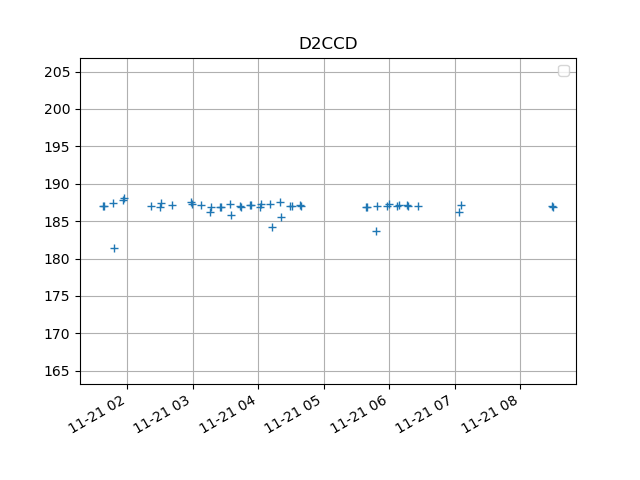

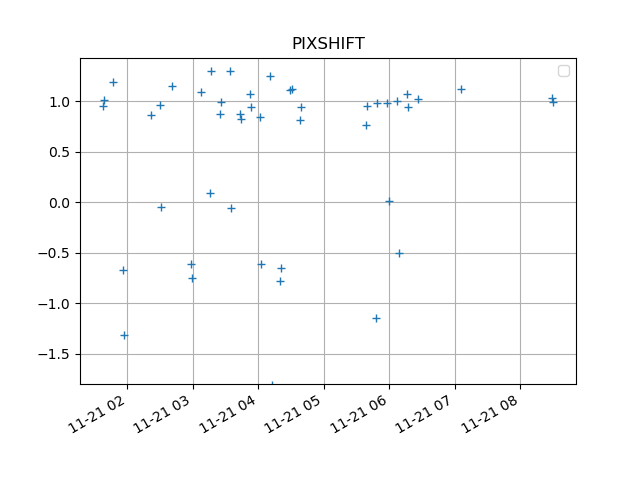

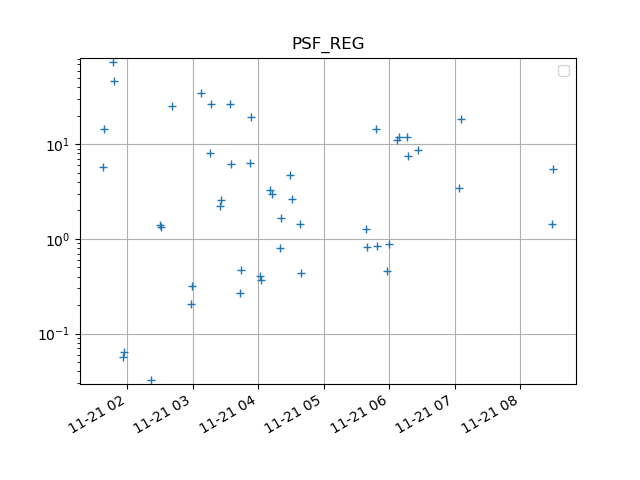

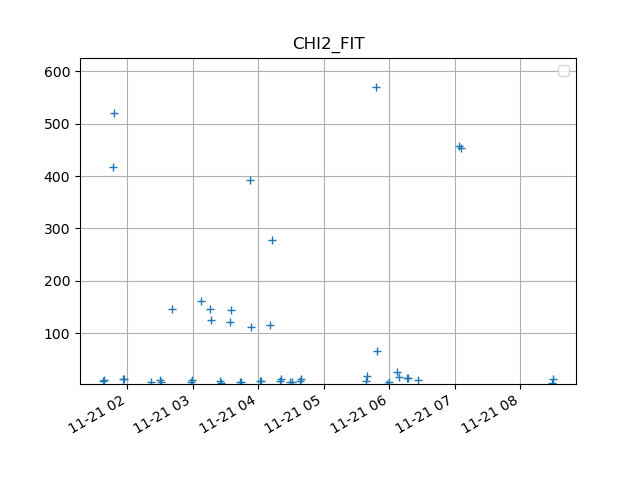

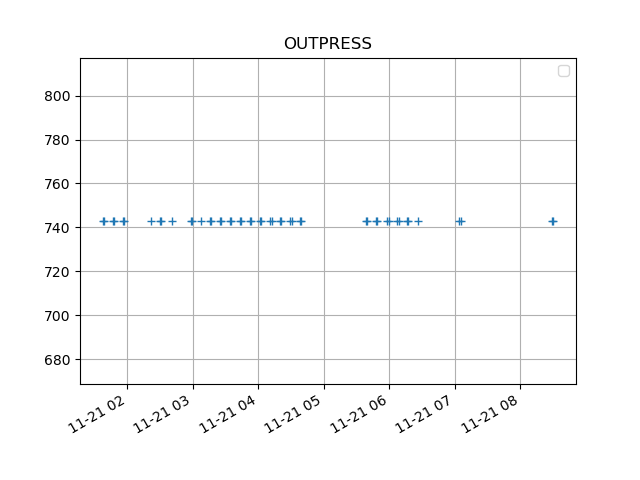

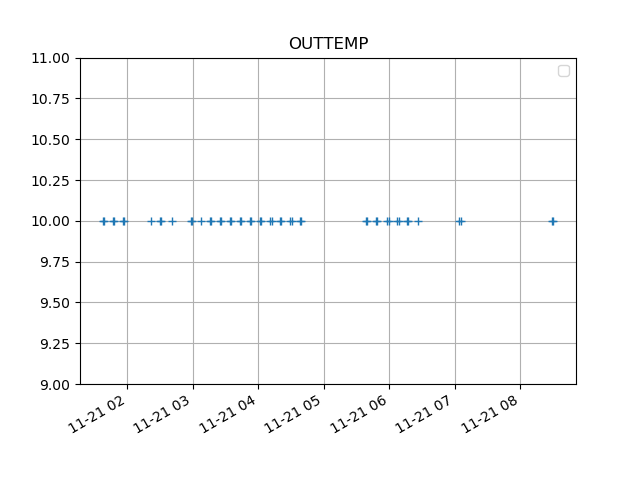

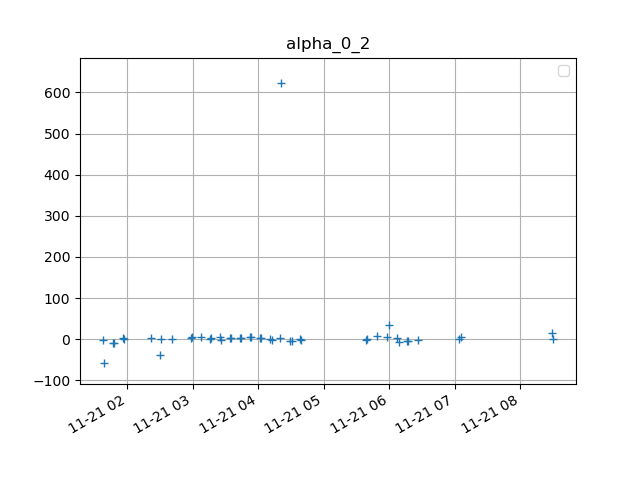

In [126]:
for col in ["D2CCD", "PIXSHIFT", "PSF_REG", "CHI2_FIT", "OUTPRESS", "OUTTEMP", "alpha_0_2"]:
    if col not in df.columns: continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure()
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"], rec[col], yerr=rec[col_err], linestyle="none", marker="+")
    else:
        plt.plot(rec["DATE-OBS"], rec[col], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col]), 1.1*np.max(rec[col])))
    if "PSF_REG" in col:
        plt.yscale("log")
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [127]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

31
30
30
26
26
21


In [128]:
len(filtered)

48

In [129]:
np.sum(filtered)

21

### Spectrum fits

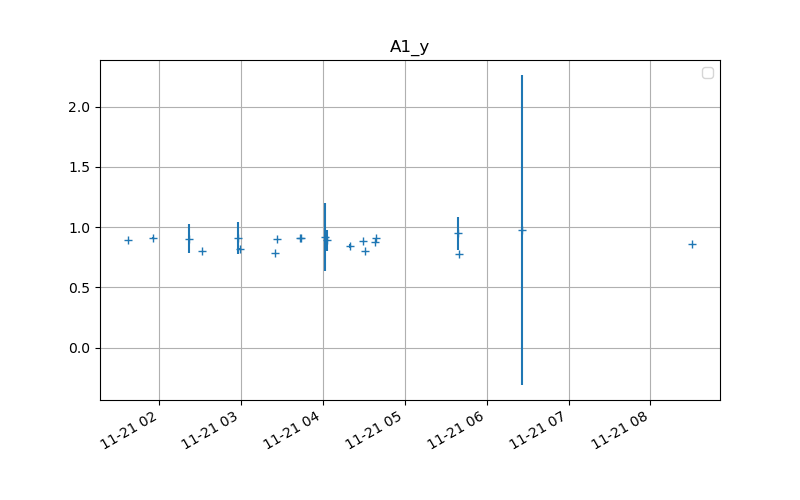

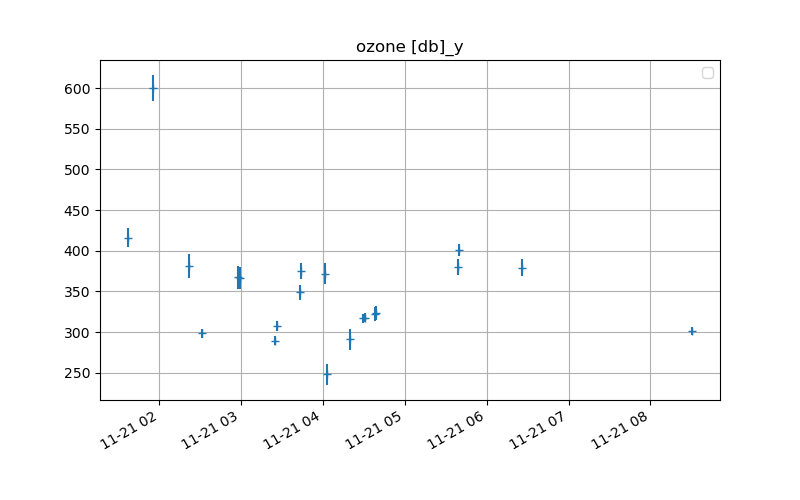

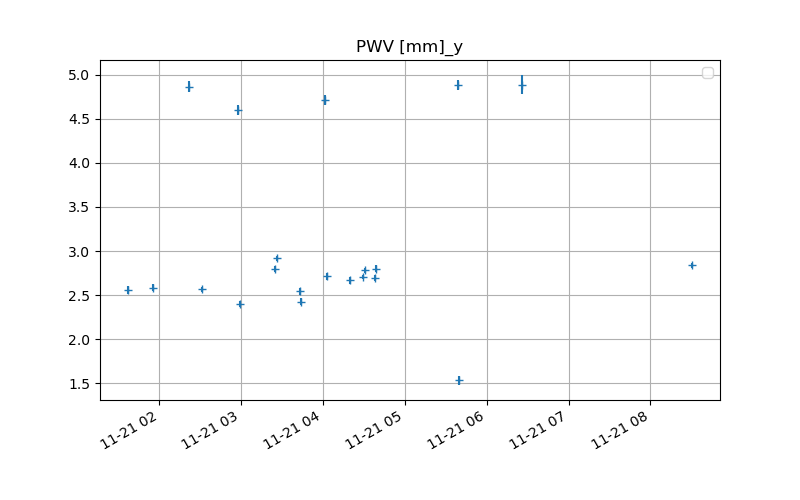

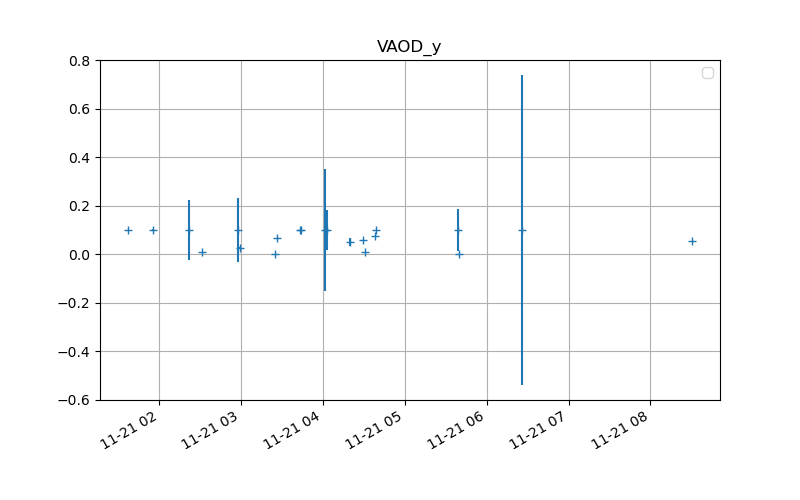

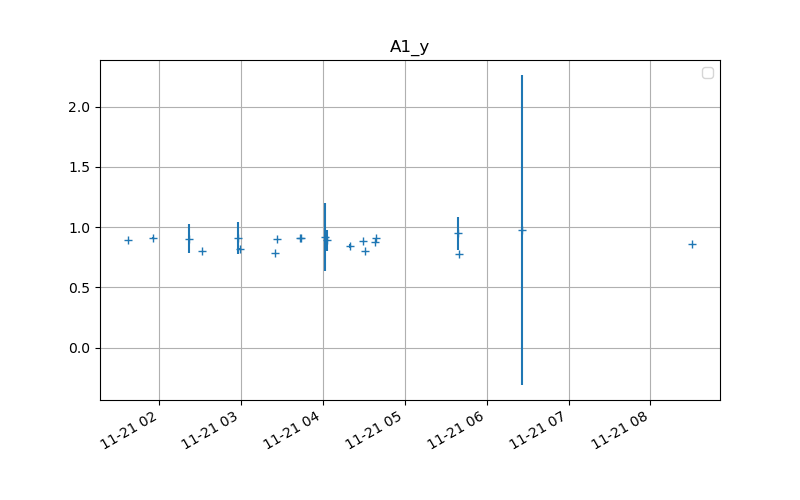

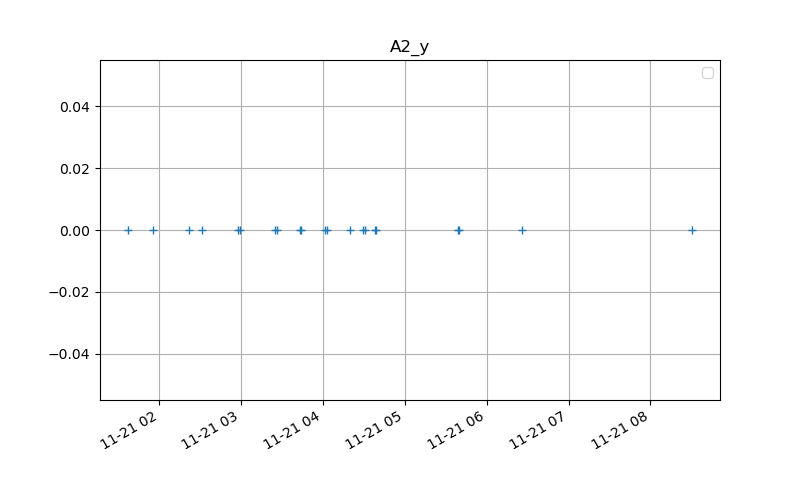

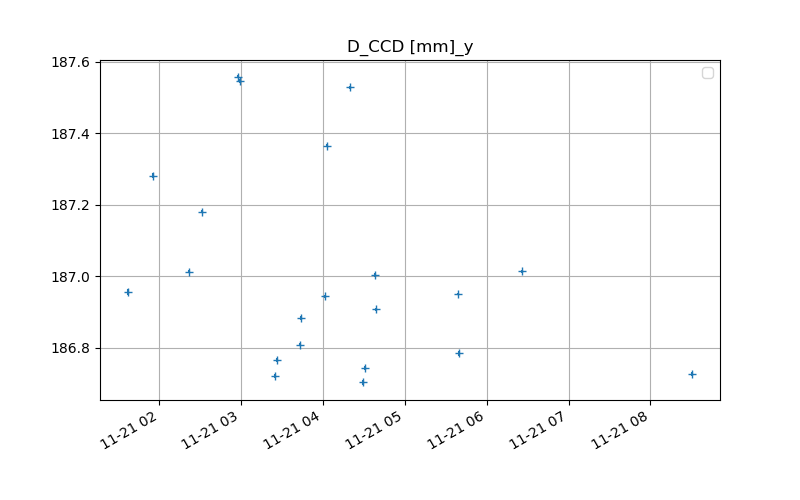

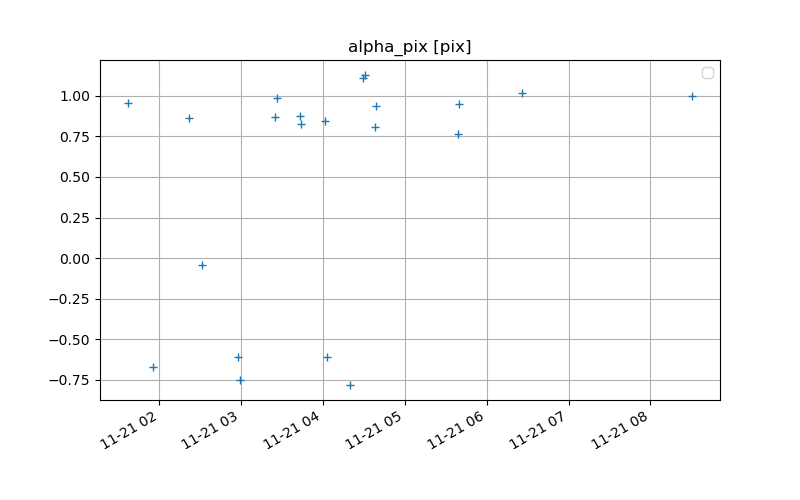

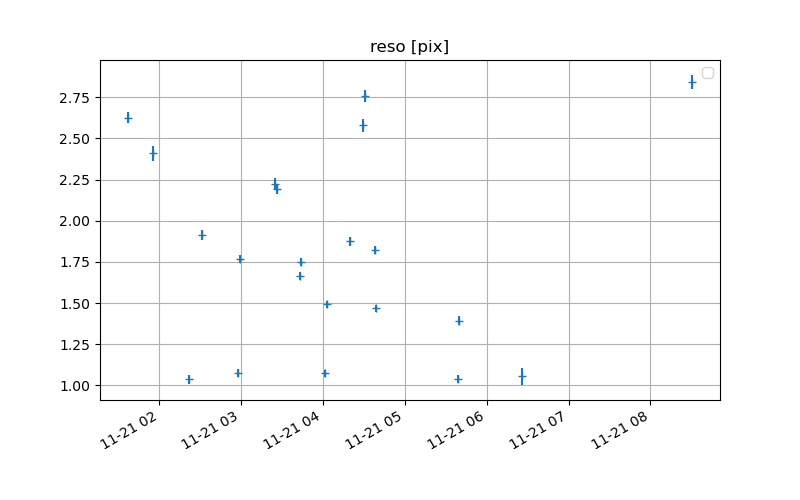

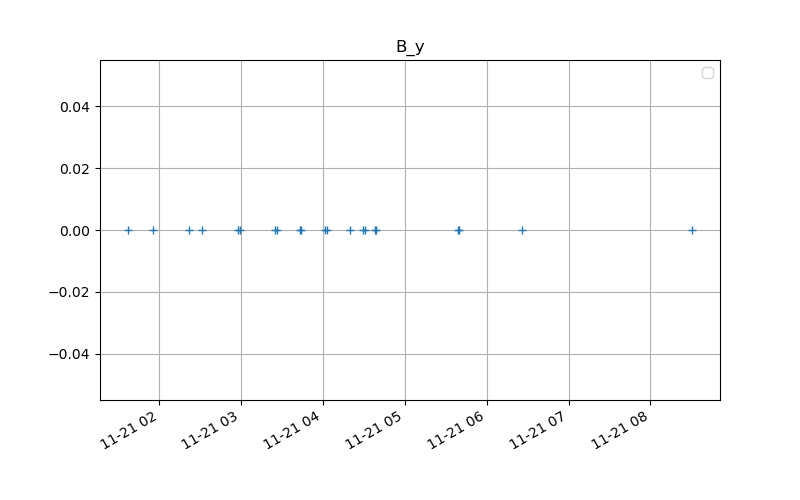

In [130]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A1_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [pix]", "B_y"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"][filtered], rec[col][filtered], yerr=rec[col_err][filtered], linestyle="none", marker="+")
    else:
        plt.plot(rec["DATE-OBS"][filtered], rec[col][filtered], linestyle="none", marker="+")
    #plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [131]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

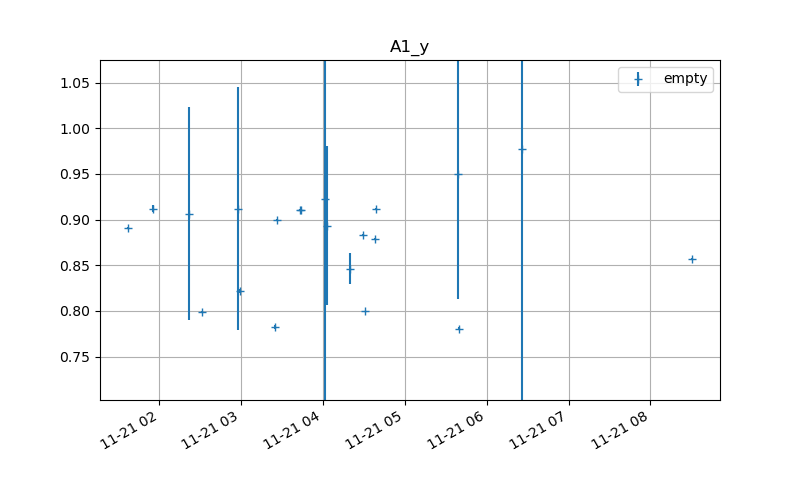

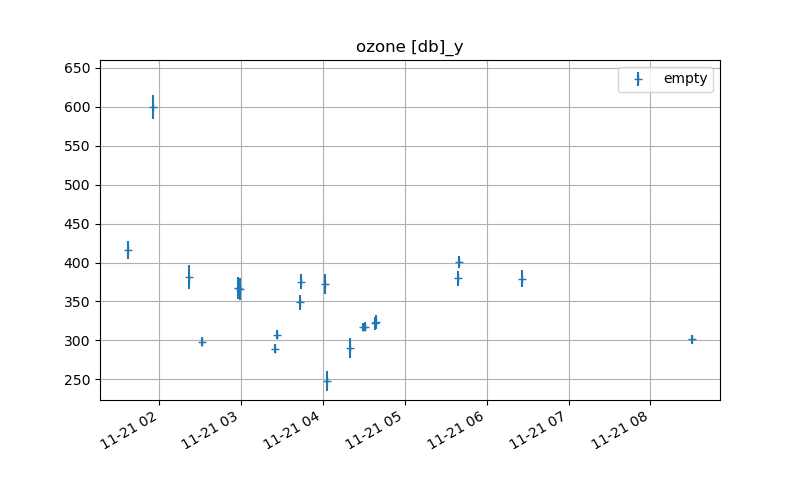

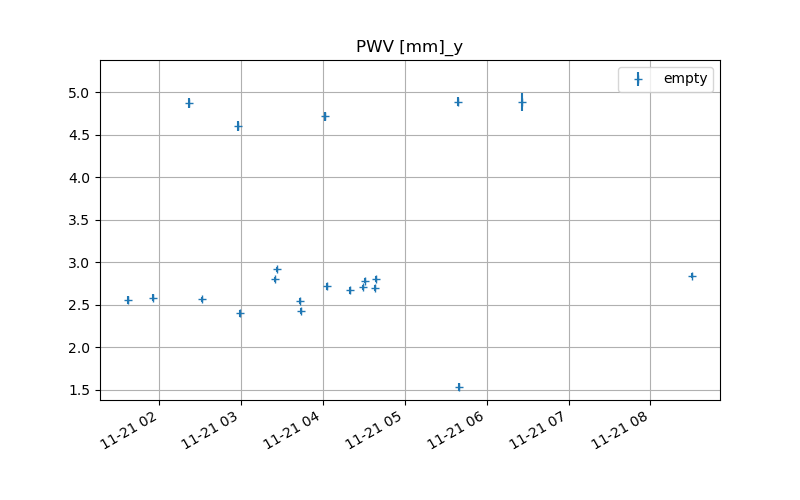

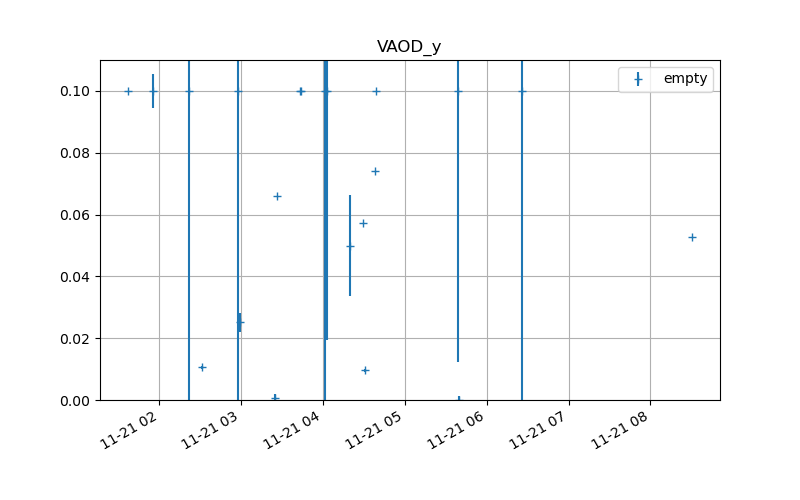

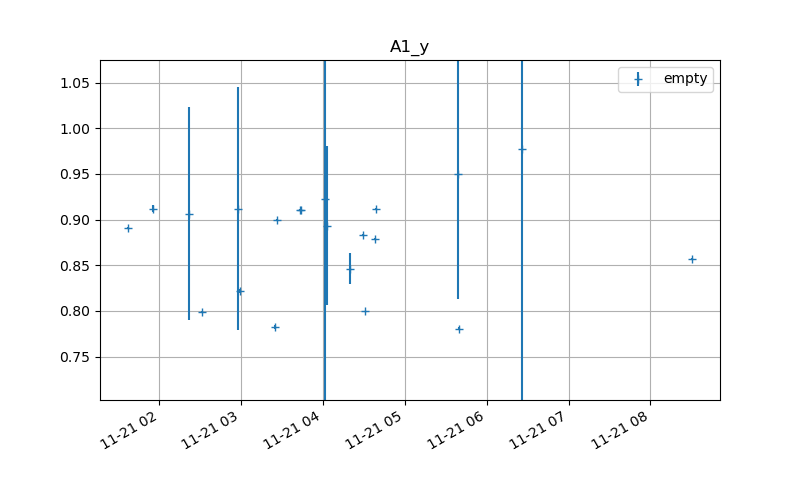

/tmp/ipykernel_45847/642574518.py:17: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))


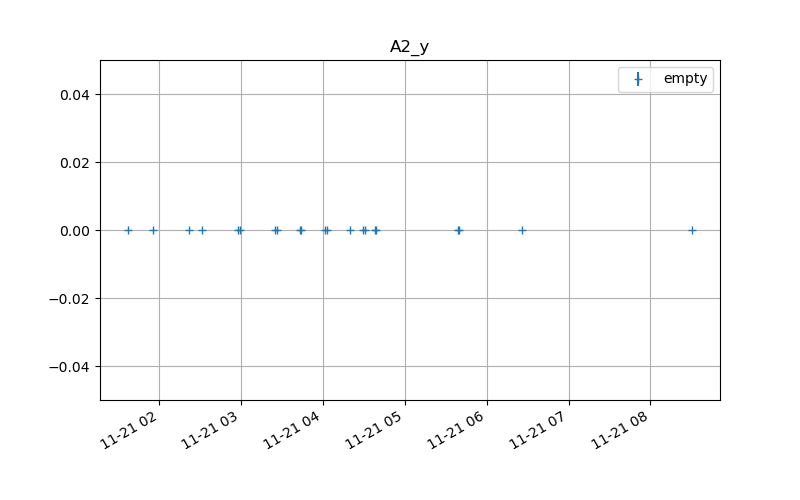

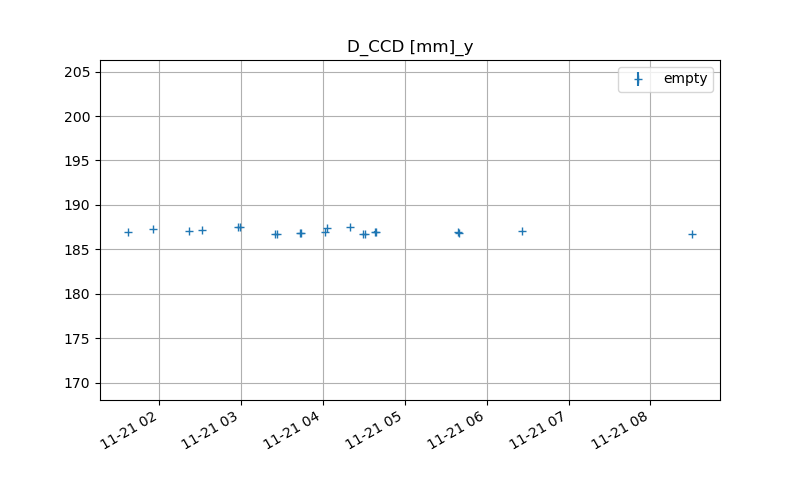

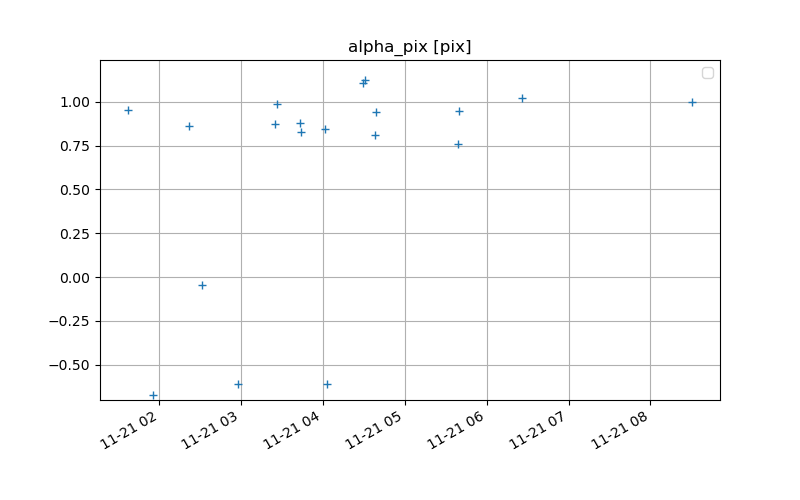

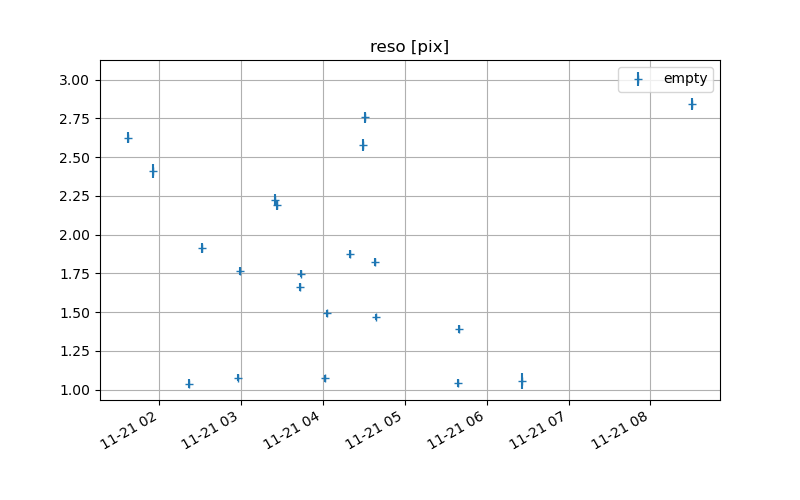

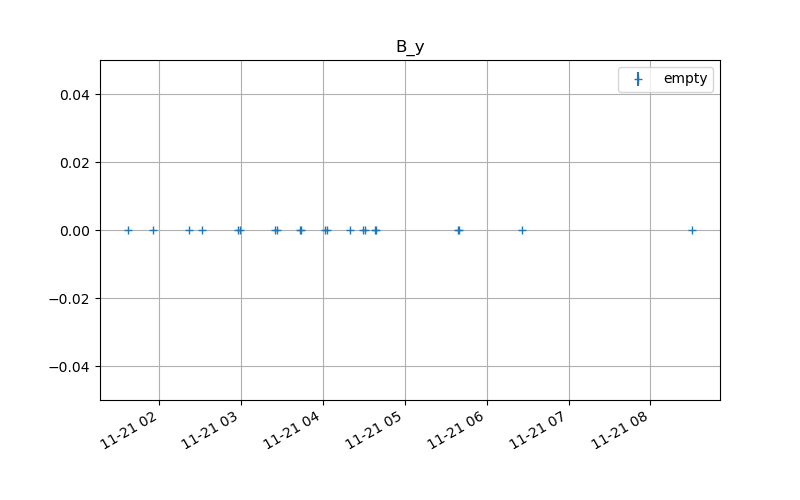

In [132]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A1_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [pix]", "B_y"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for filt in filters:
        if filt in ["HD60753", "HD37962"]:
            continue
        index = filtered & (rec["FILTER"] == filt)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=filt)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [133]:
stars = np.unique(rec["TARGET"])
stars

array(['HD185975', 'HD2811', 'HD38666'], dtype=object)

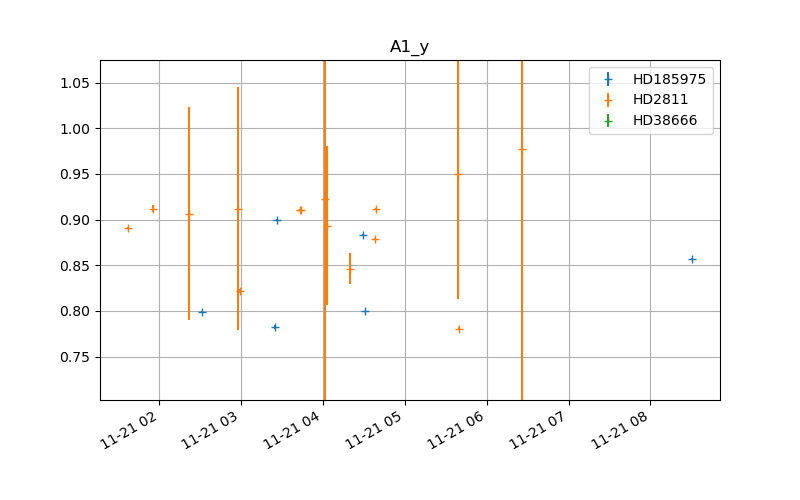

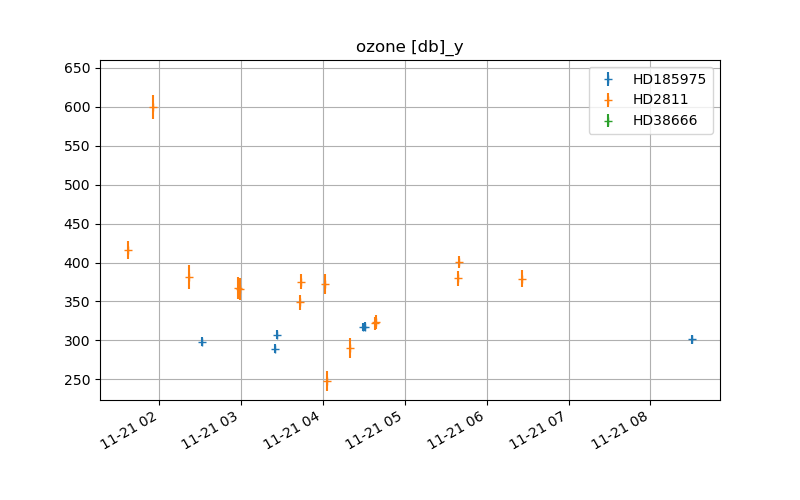

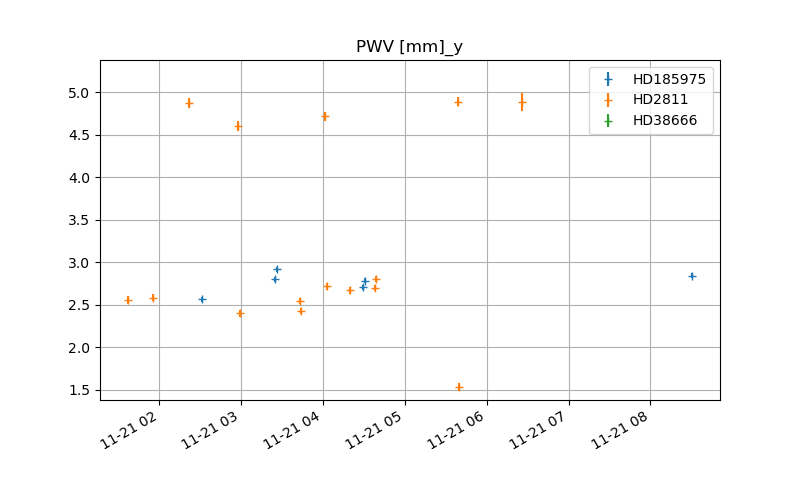

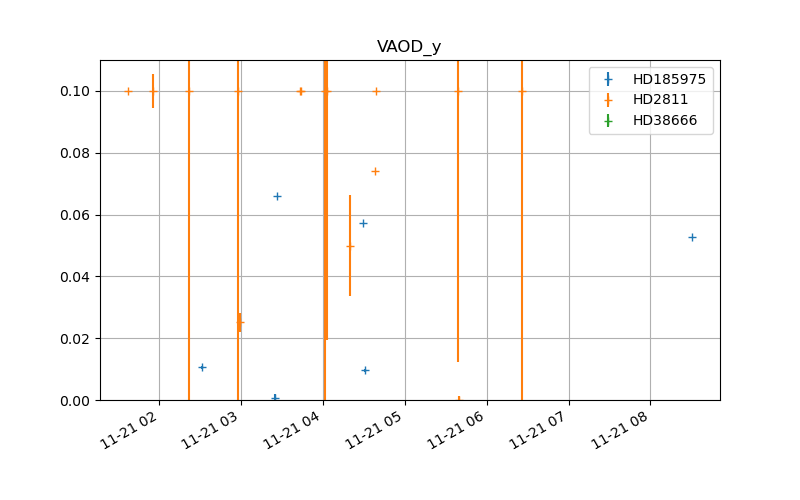

/tmp/ipykernel_45847/957792930.py:17: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))


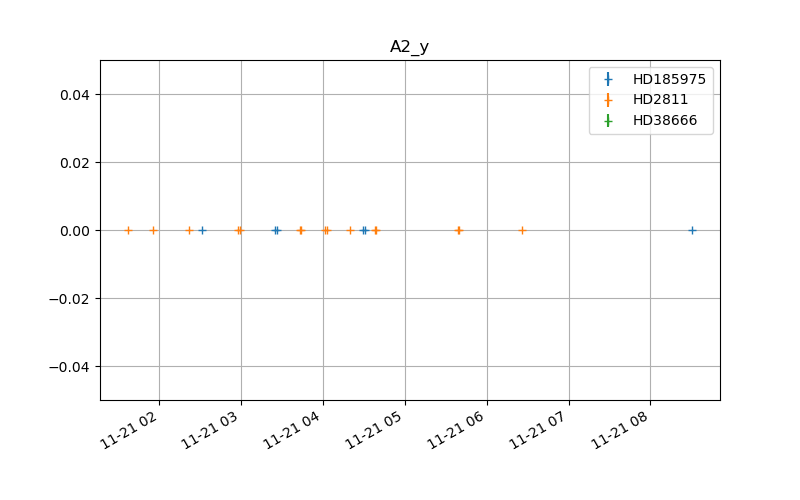

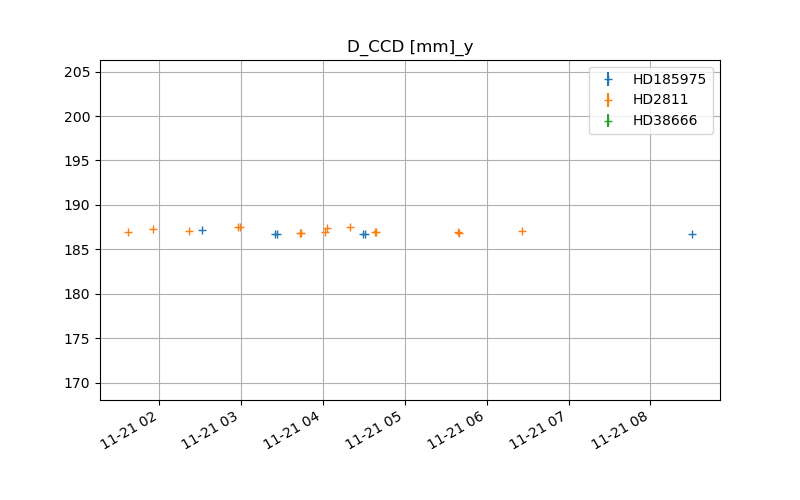

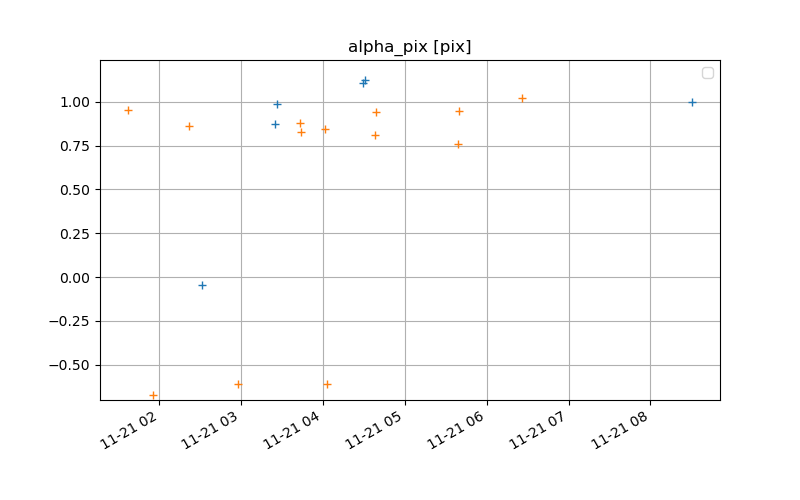

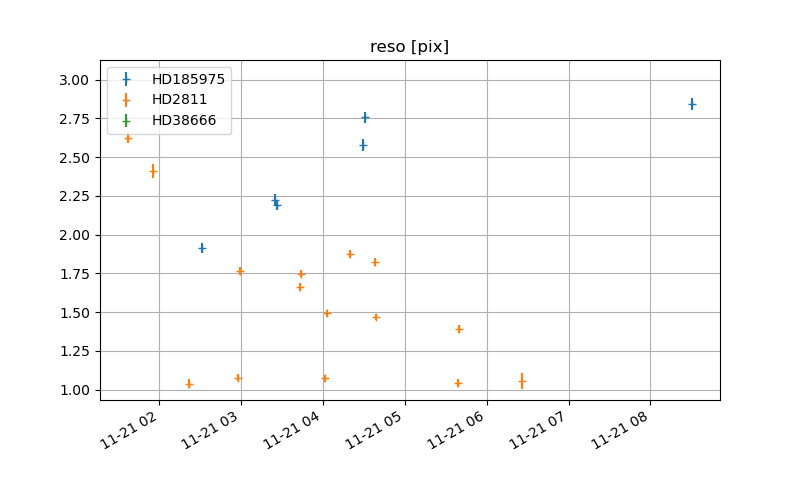

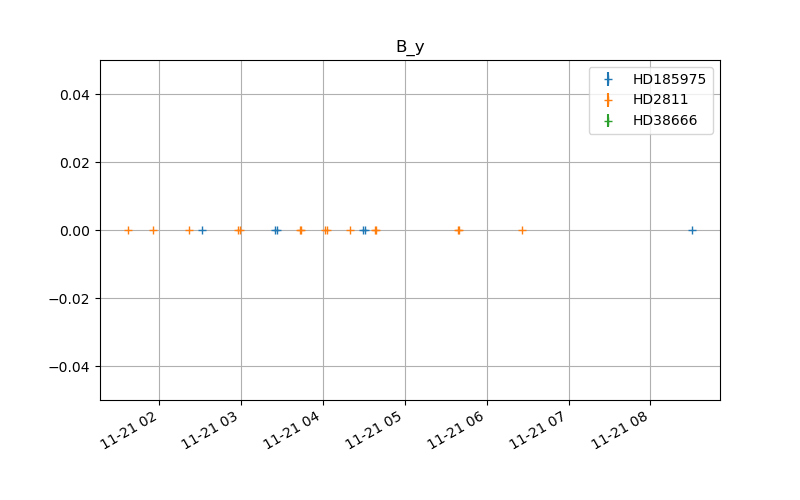

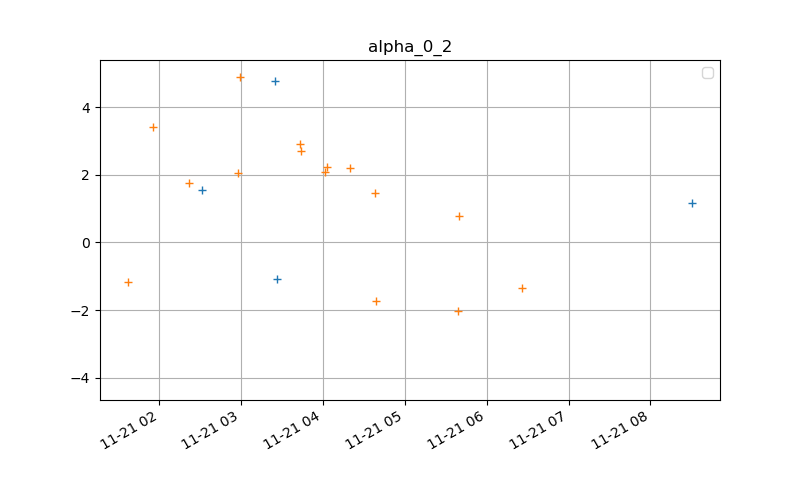

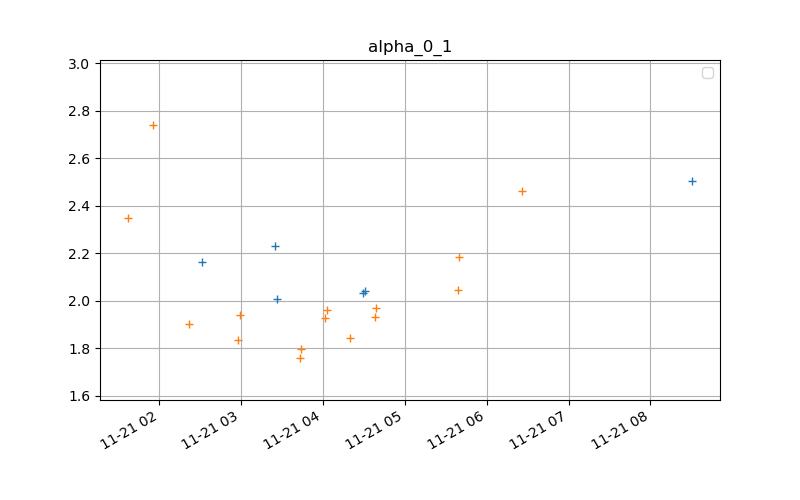

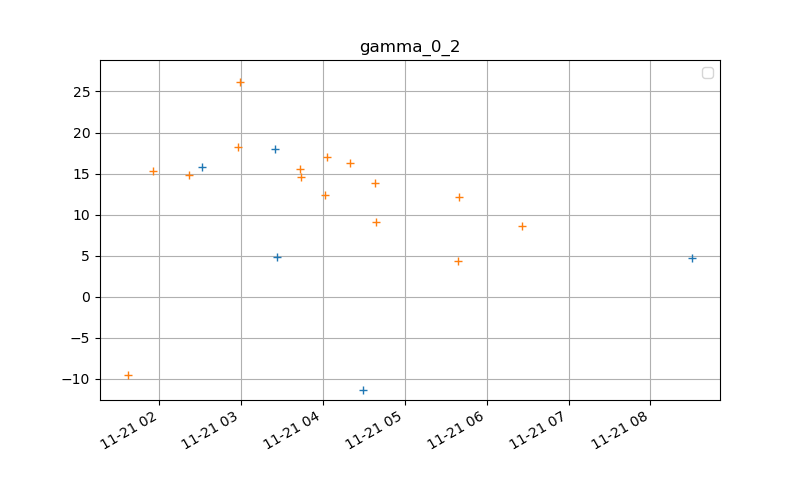

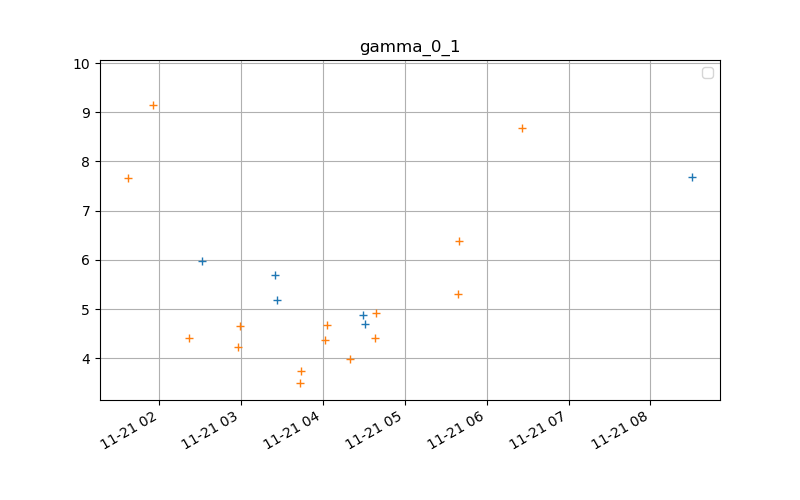

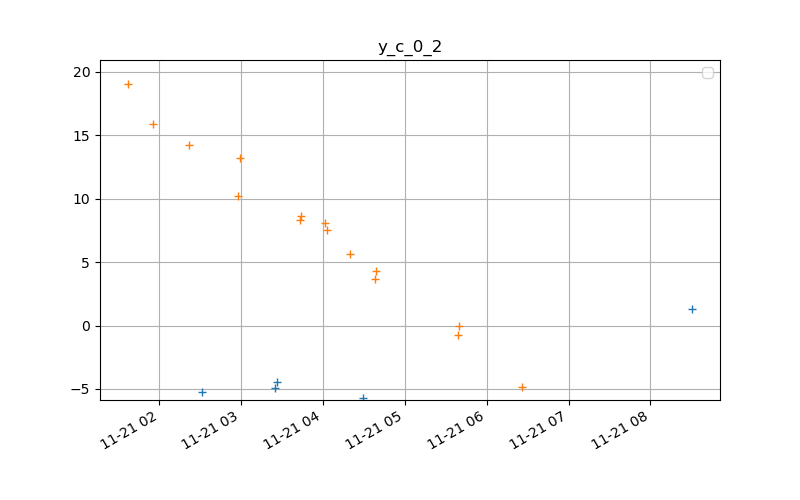

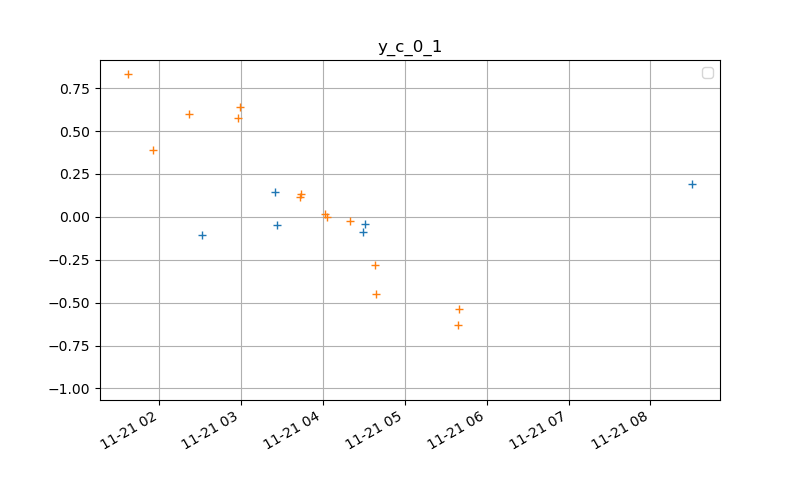

In [134]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [pix]", "B_y", "alpha_0_2", "alpha_0_1", "gamma_0_2", "gamma_0_1", "y_c_0_2", "y_c_0_1"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        #if star not in ["HD185975"]:
        #    continue
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

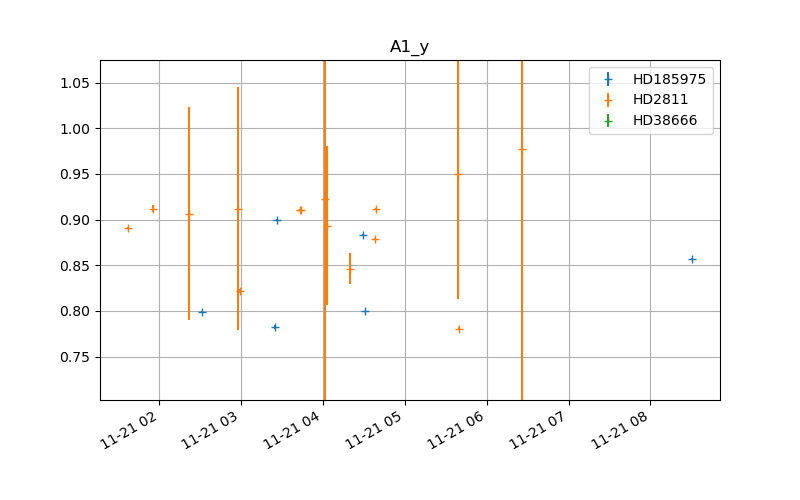

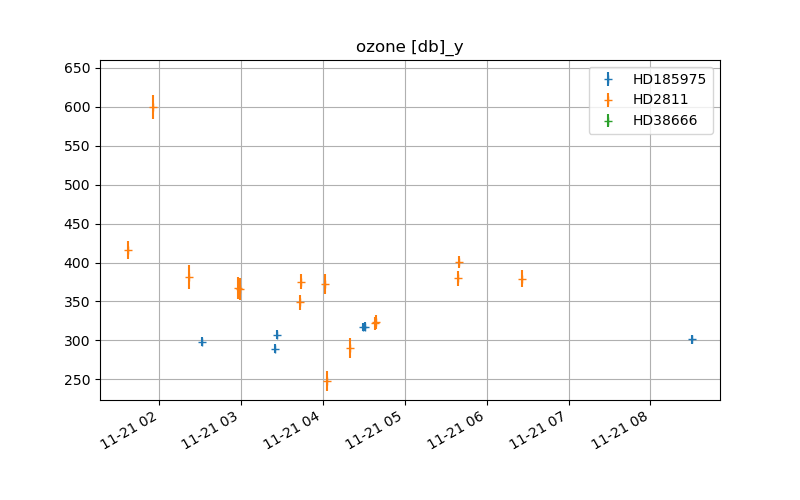

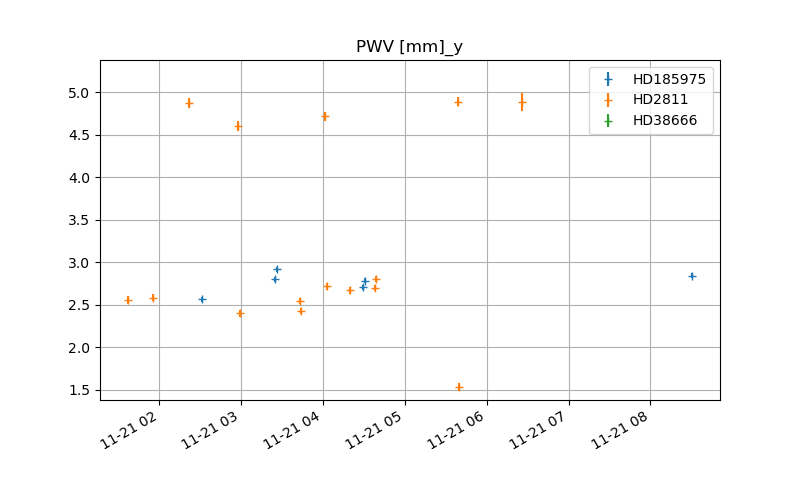

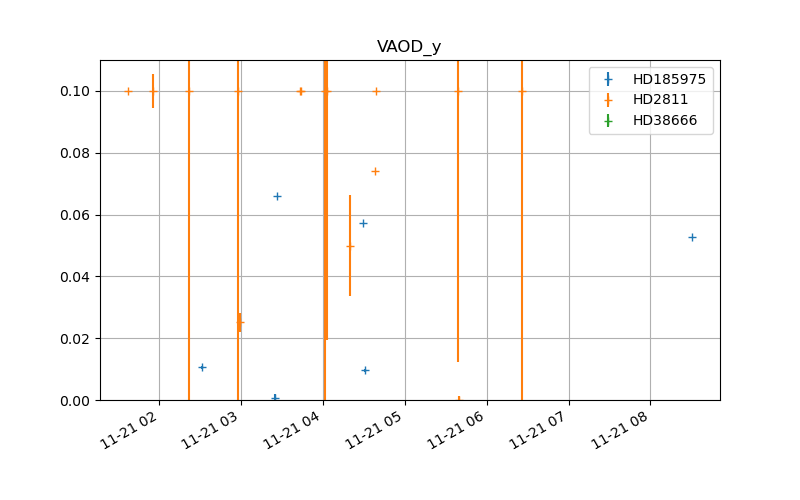

/tmp/ipykernel_45847/957792930.py:17: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))


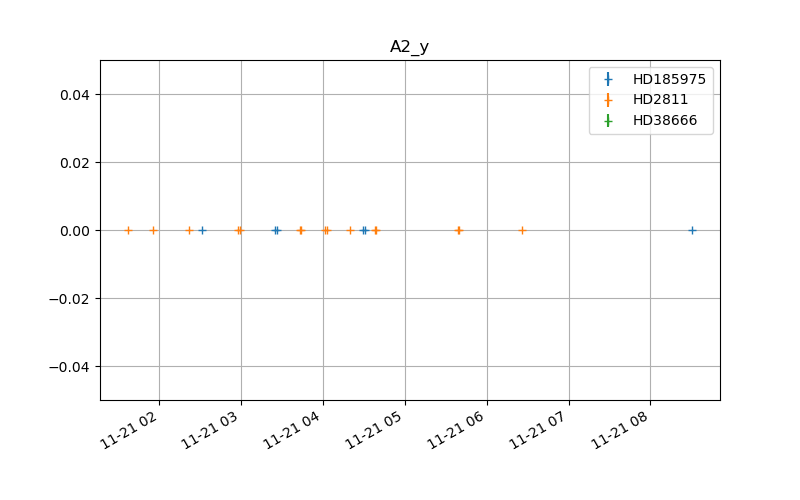

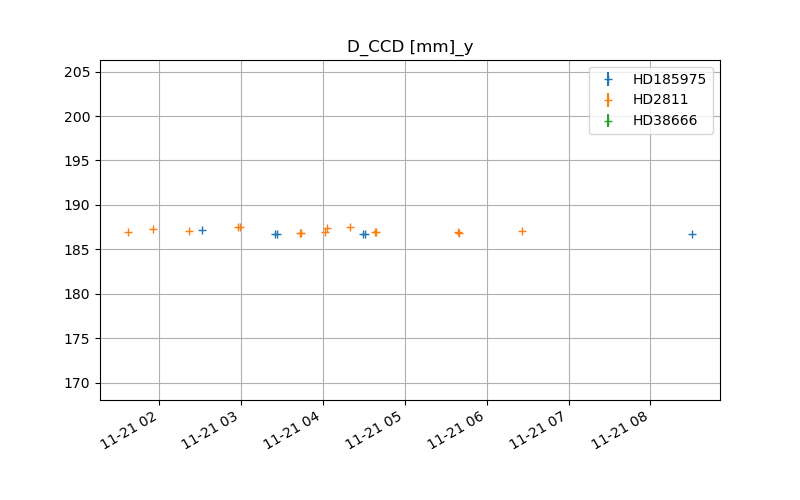

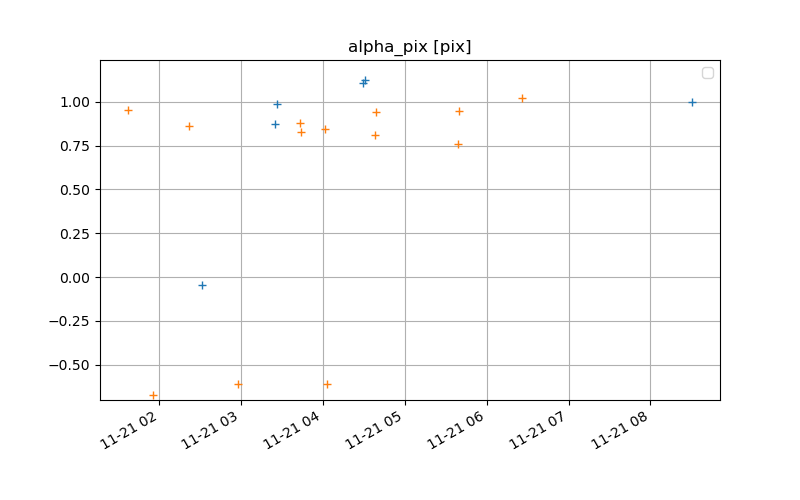

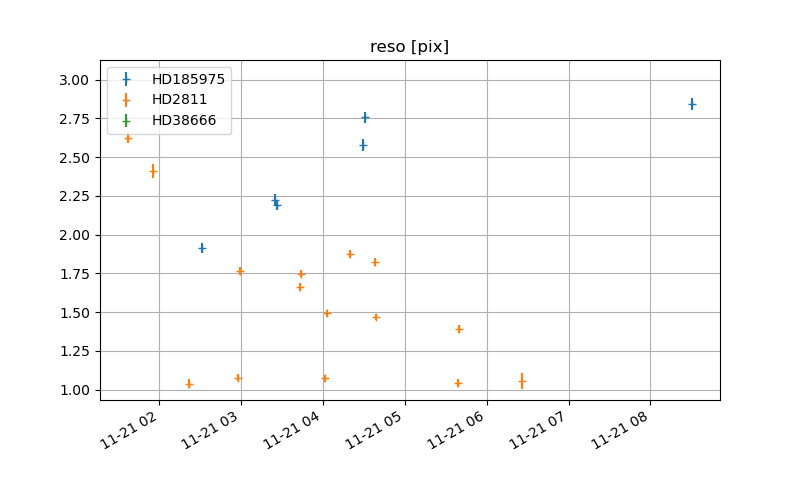

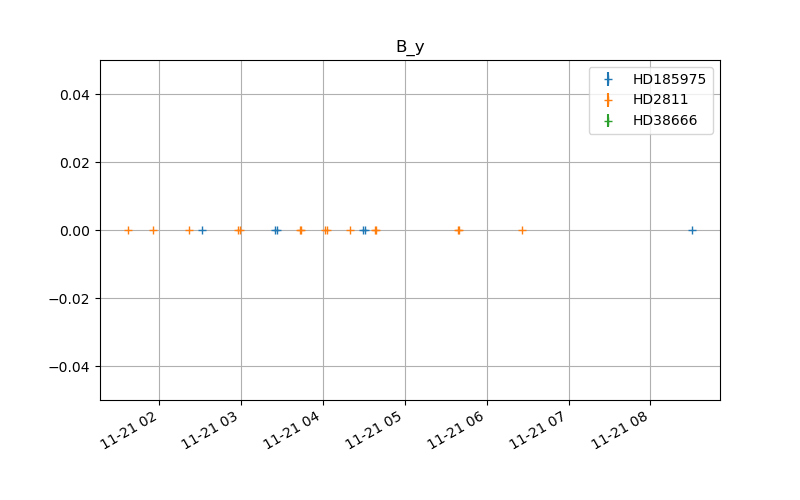

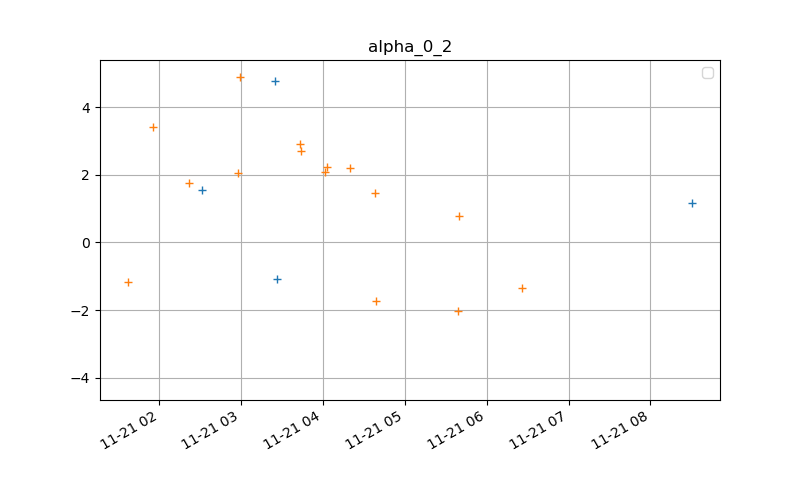

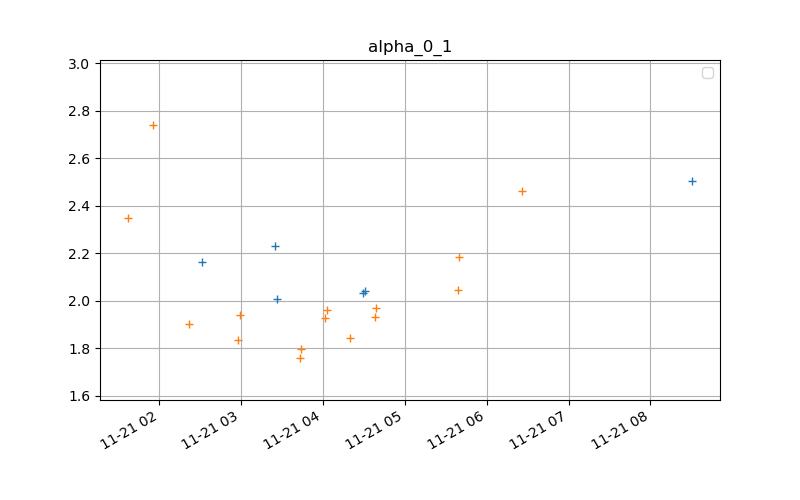

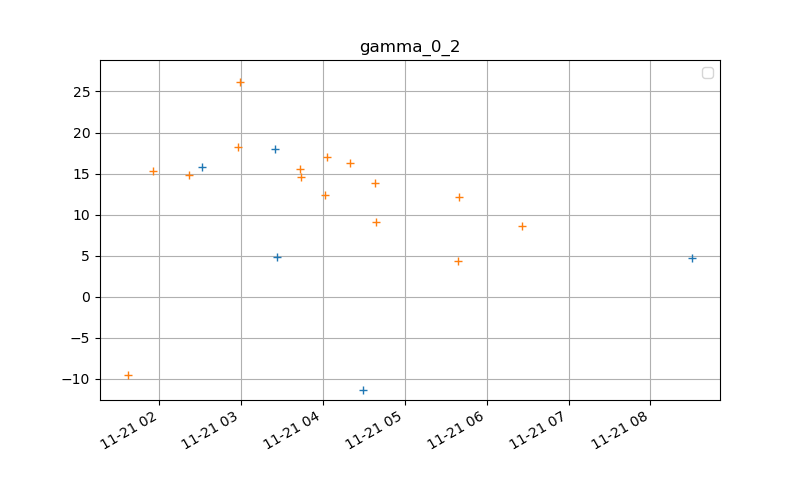

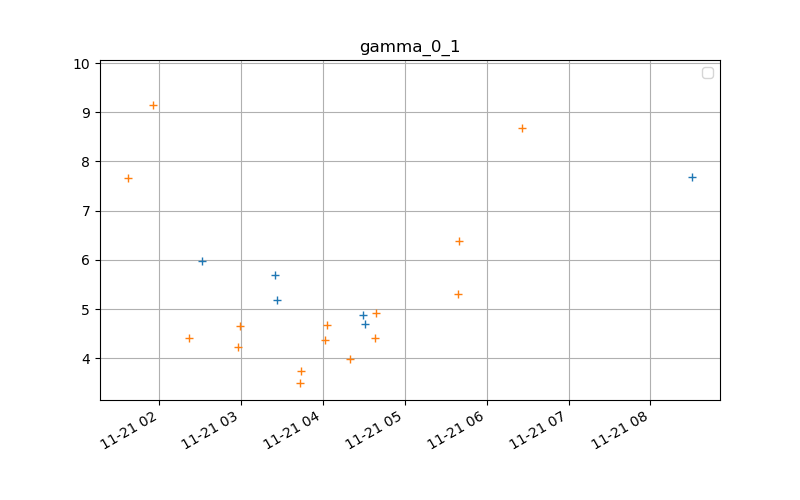

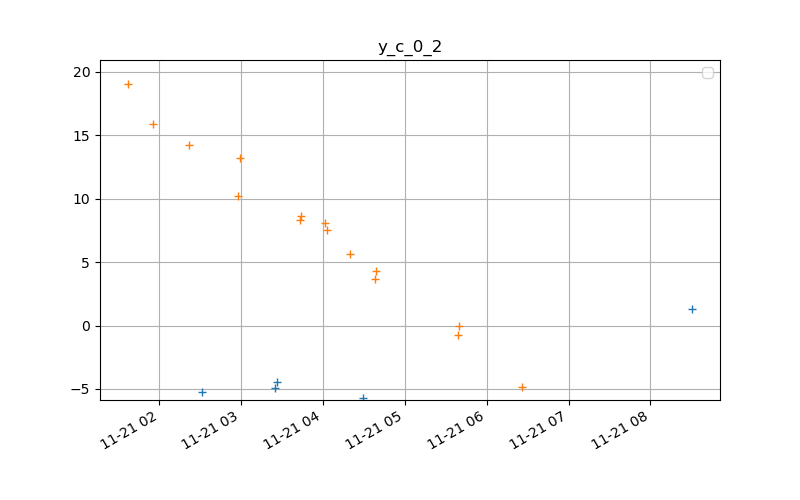

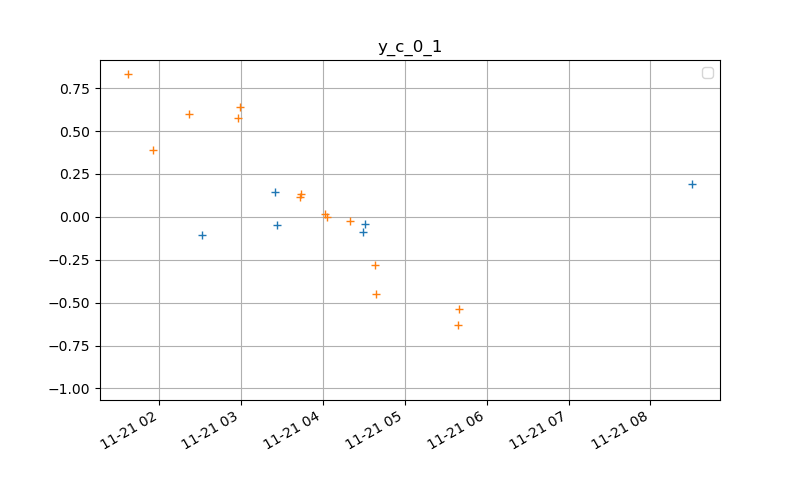

In [135]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [pix]", "B_y", "alpha_0_2", "alpha_0_1", "gamma_0_2", "gamma_0_1", "y_c_0_2", "y_c_0_1"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        #if star not in ["HD185975"]:
        #    continue
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

### Spectrogram forward model fits

In [137]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

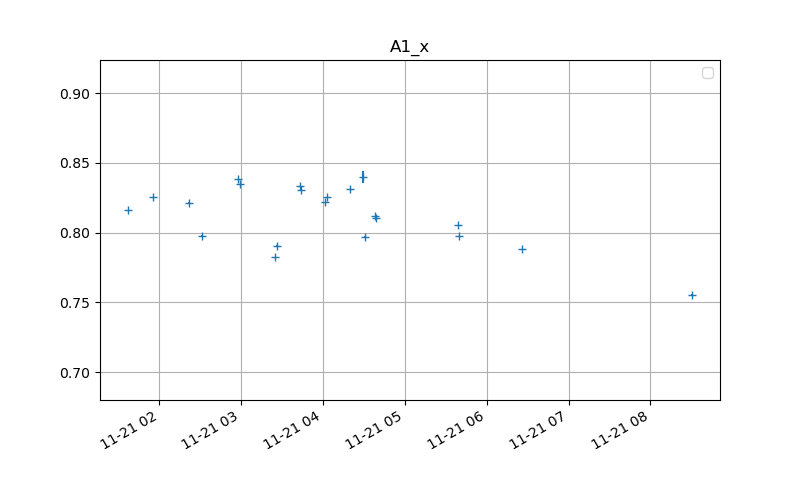

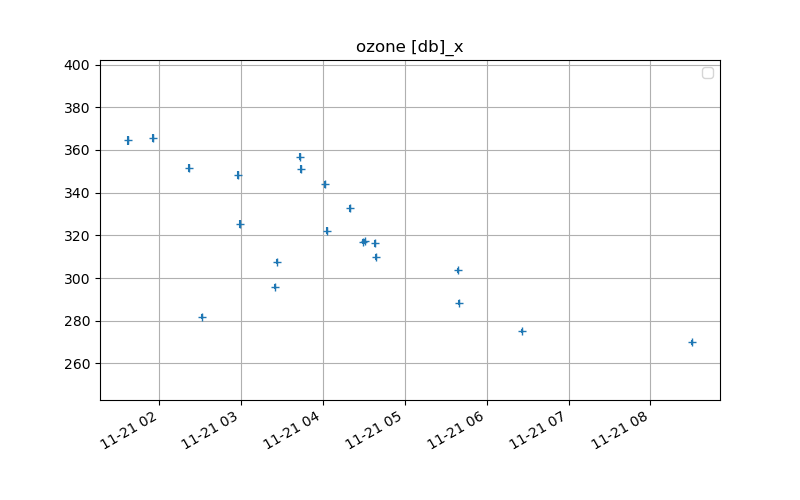

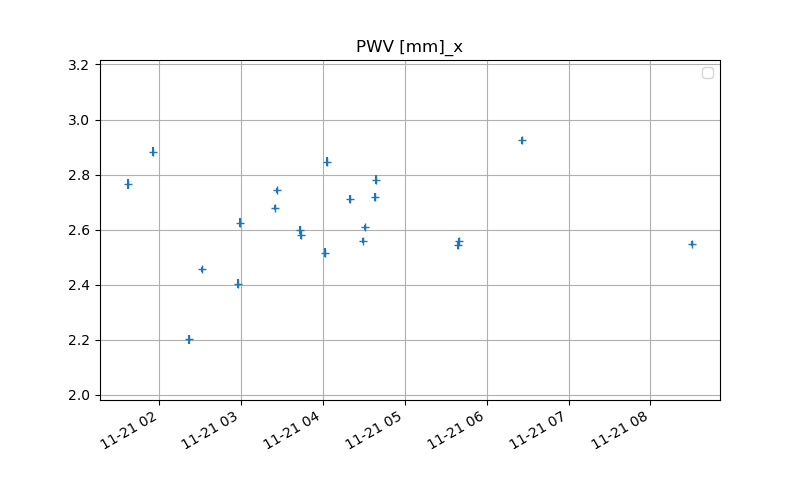

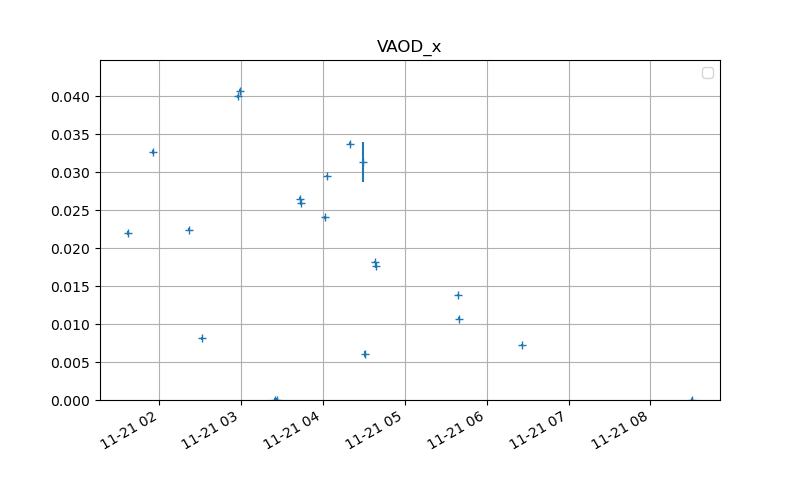

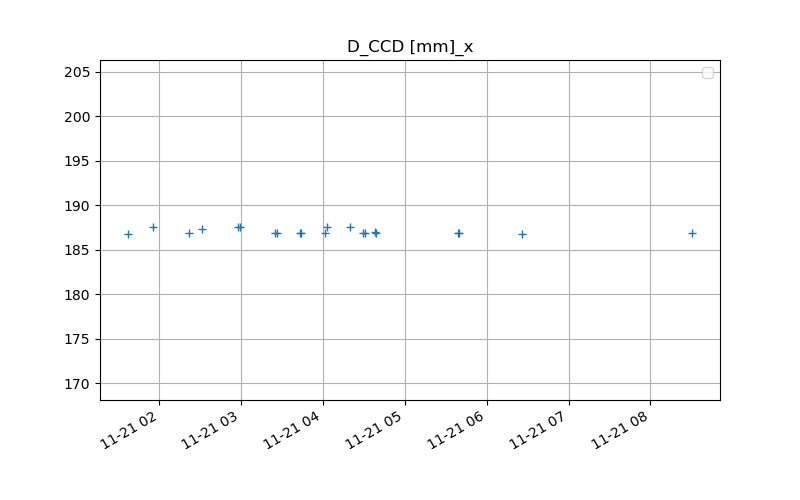

In [138]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x"]: #, "gamma_0", "alpha_0"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for filt in filters:
        index = filtered & (rec["FILTER"] == filt)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+")
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [139]:
import matplotlib
matplotlib.pyplot.close()

In [140]:
stars = np.unique(rec["TARGET"])
stars

array(['HD185975', 'HD2811', 'HD38666'], dtype=object)

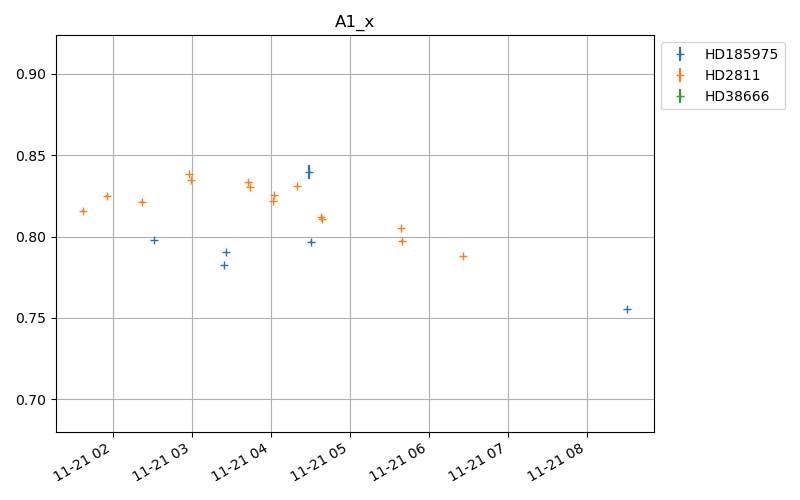

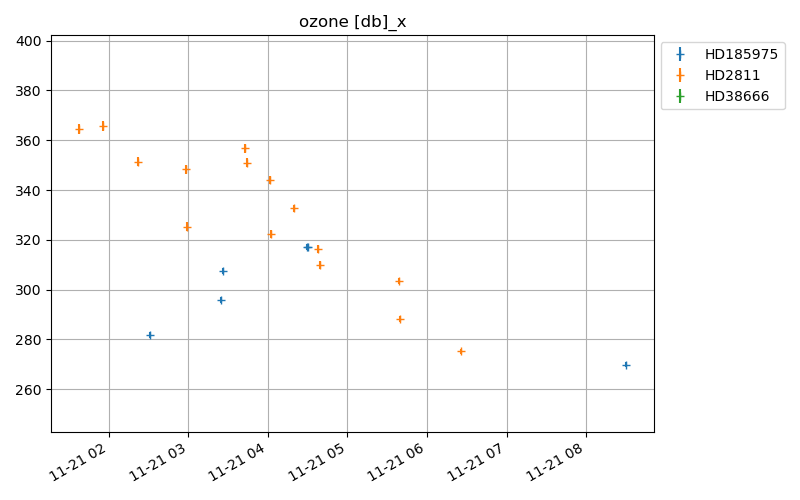

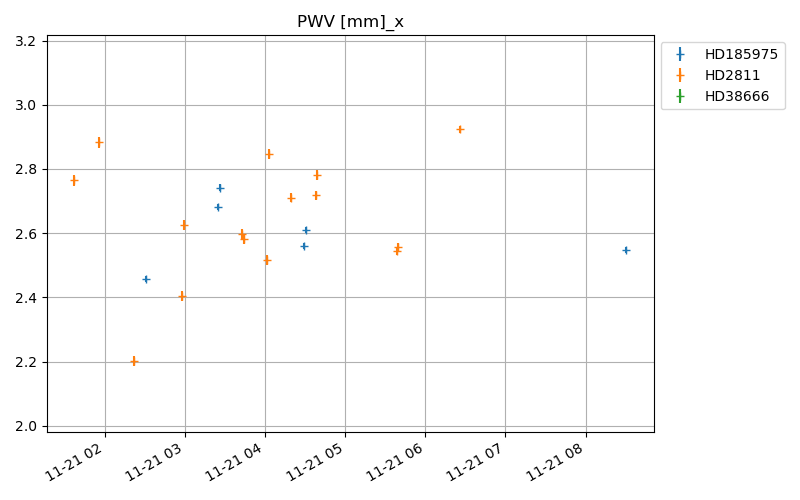

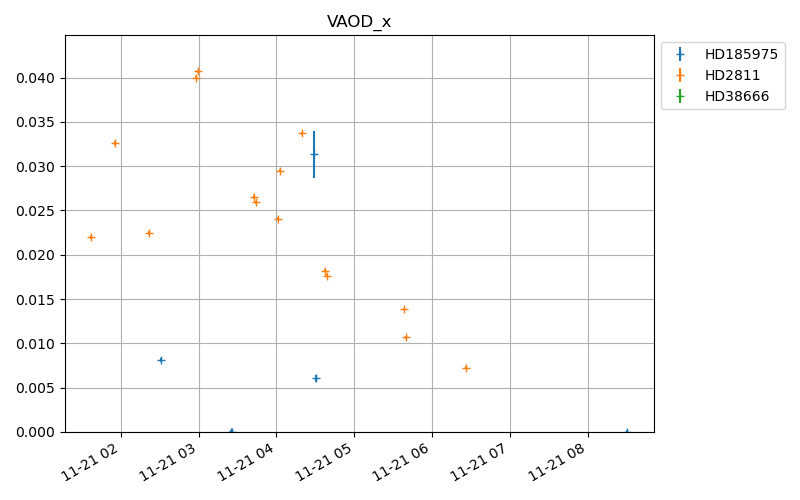

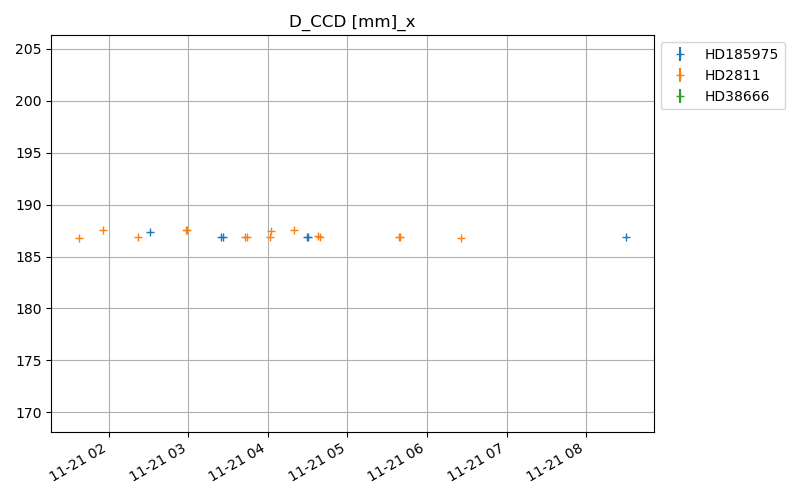

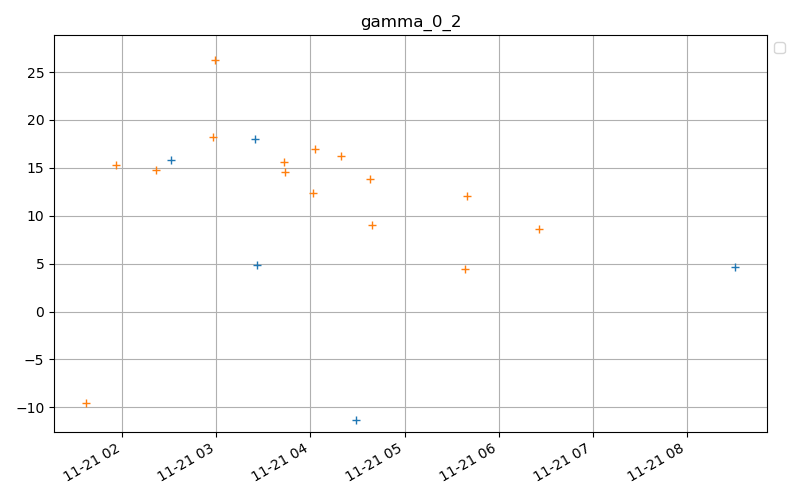

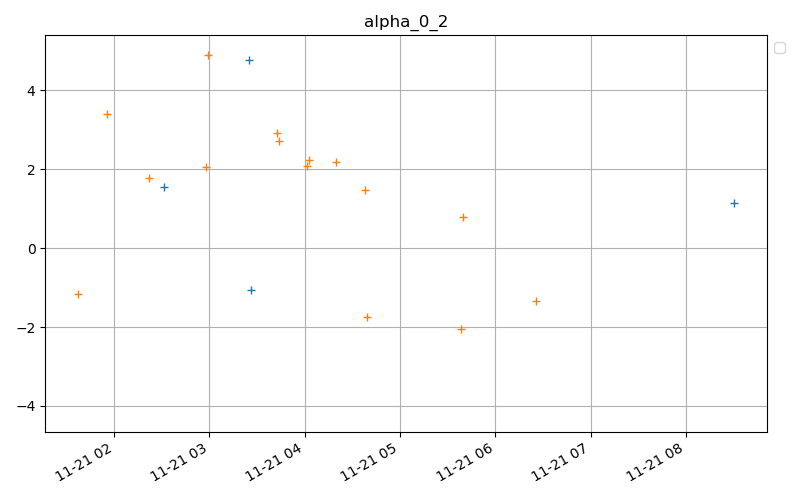

In [141]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_2", "alpha_0_2"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars : #['HD185975']: #stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

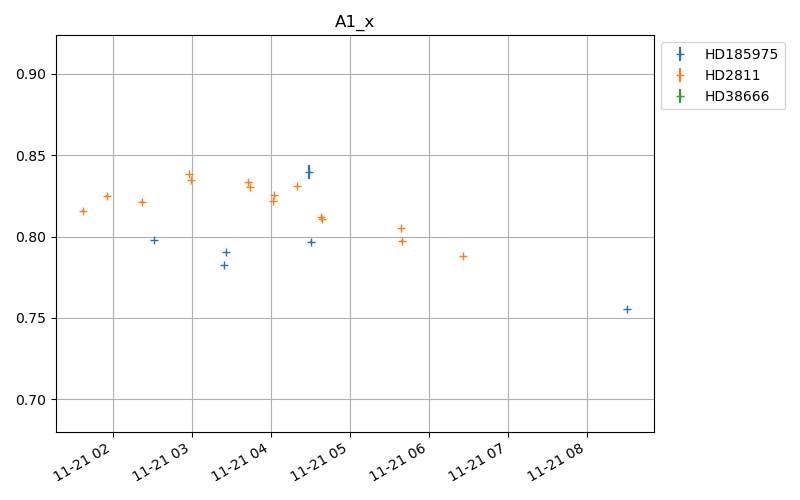

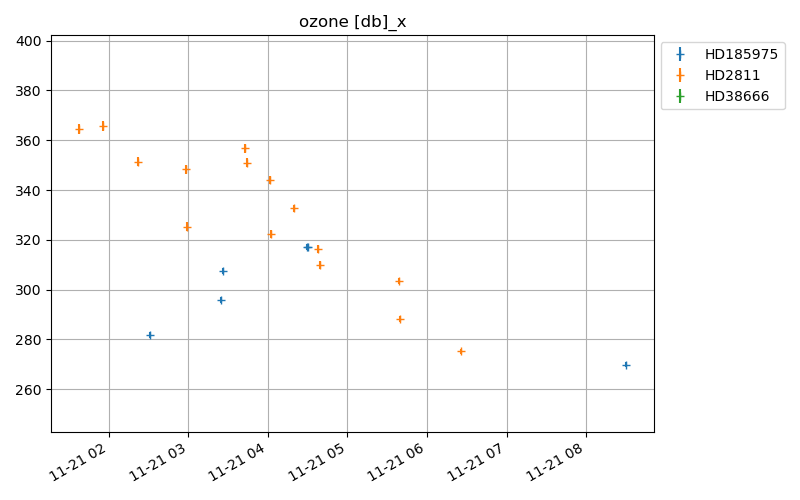

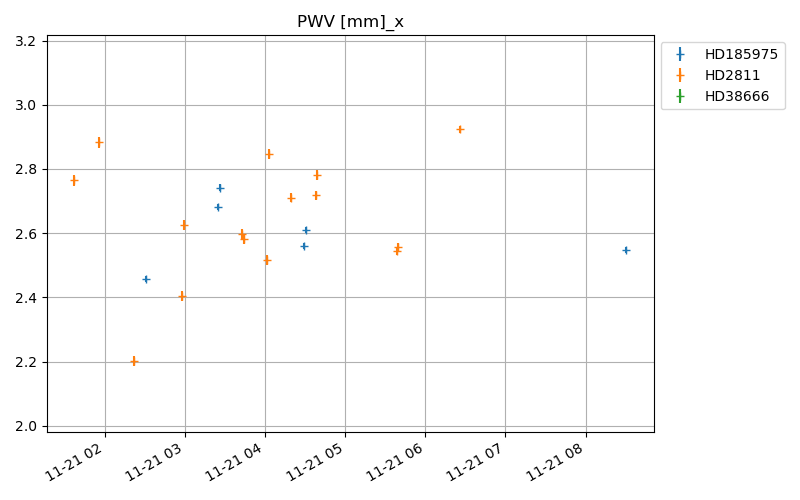

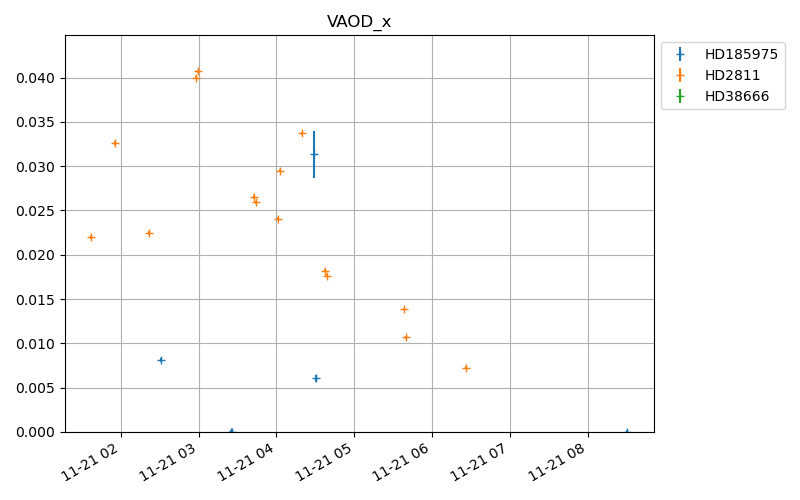

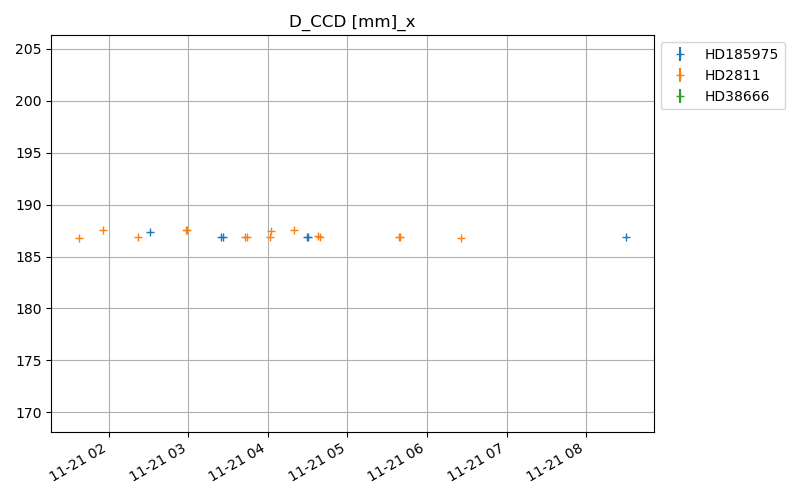

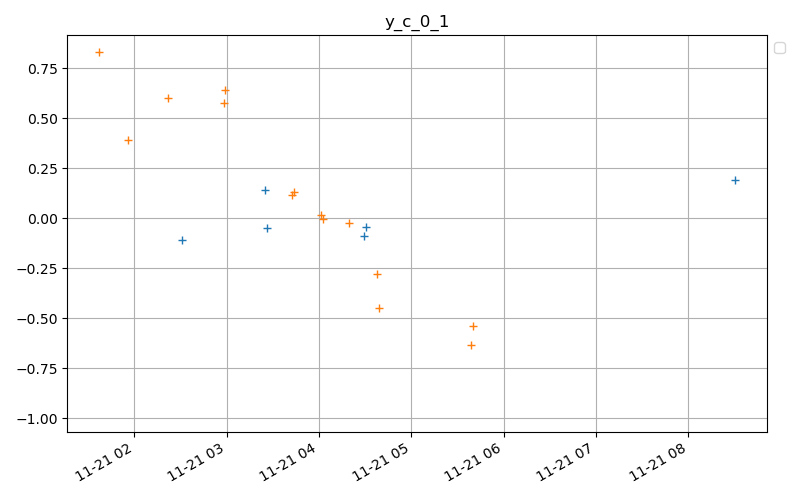

In [142]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "y_c_0_1"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

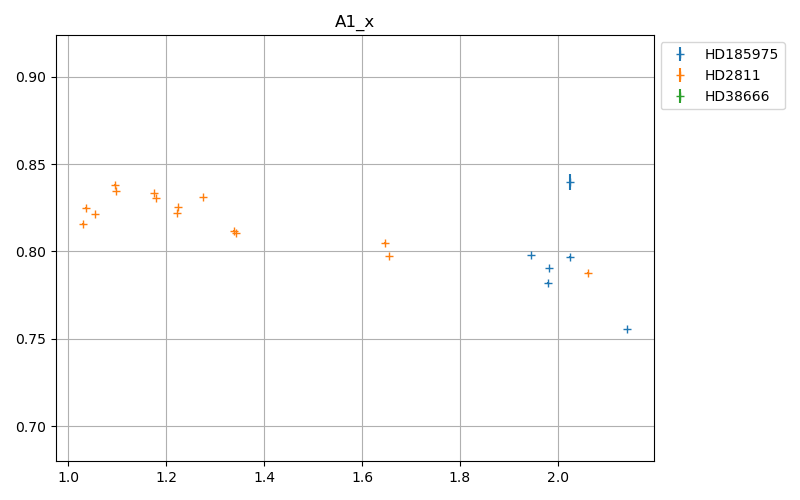

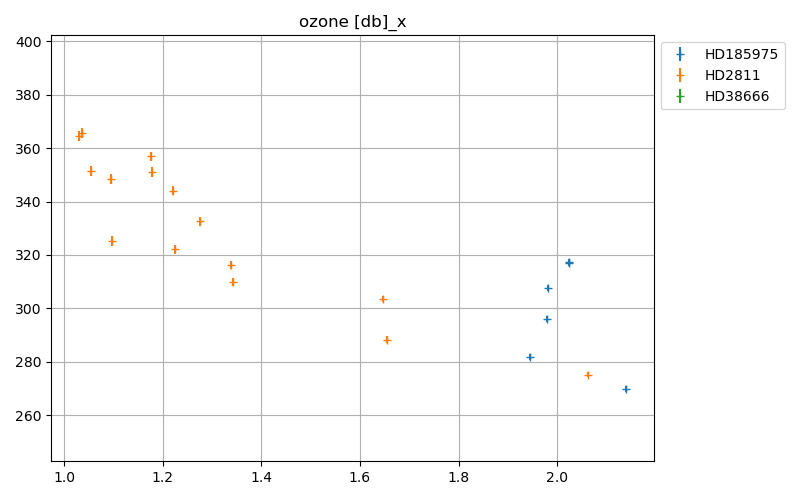

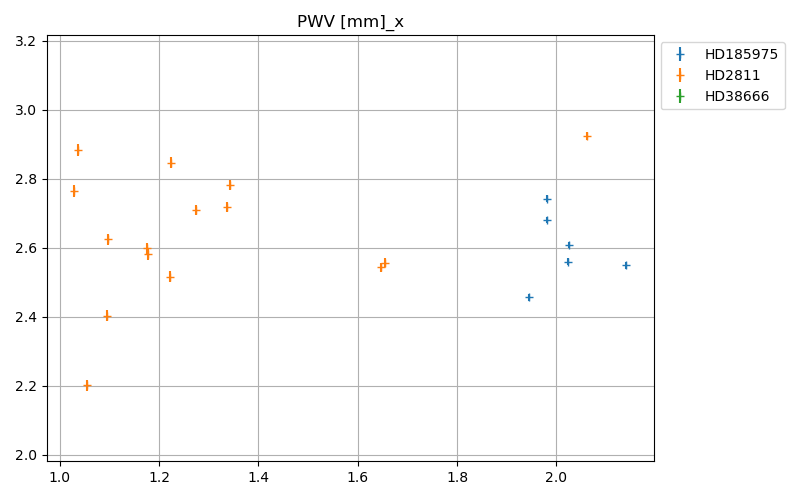

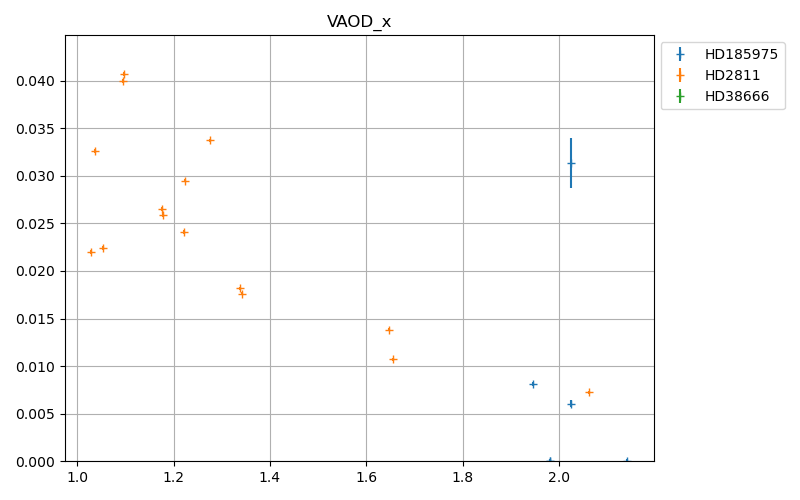

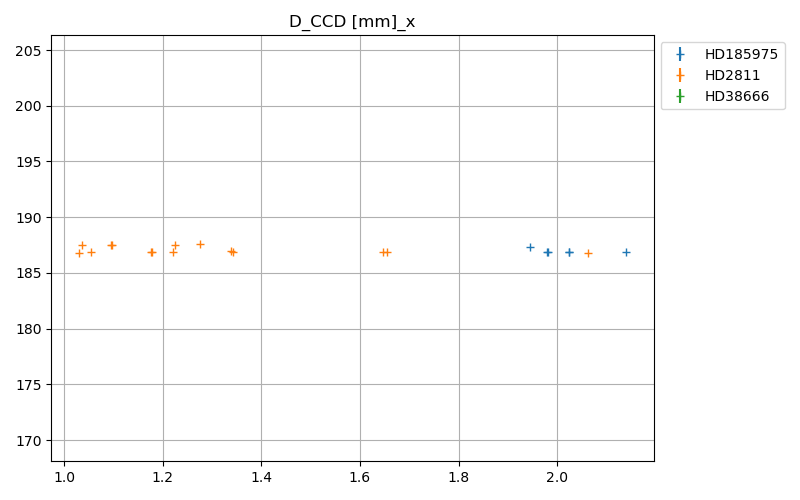

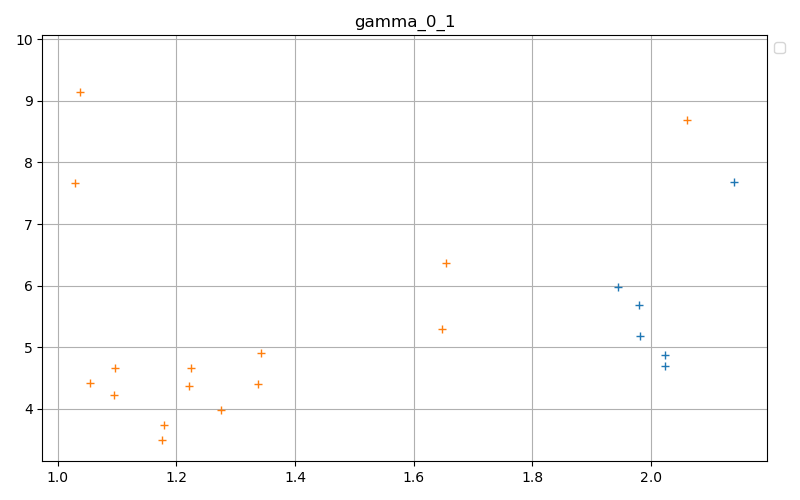

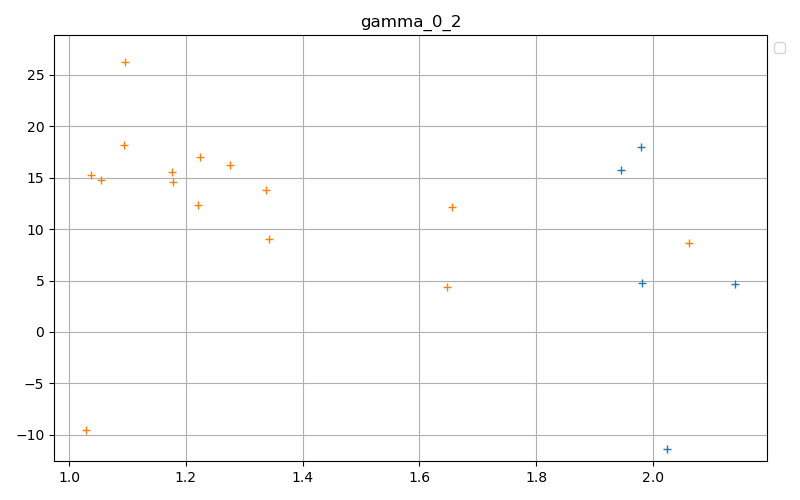

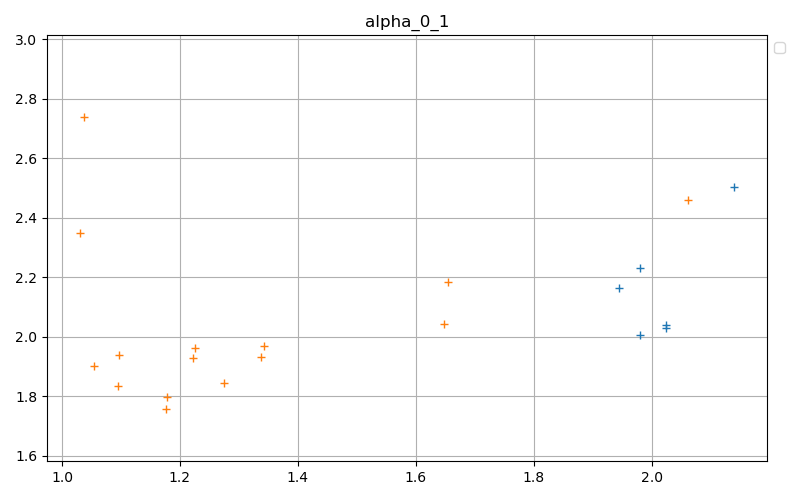

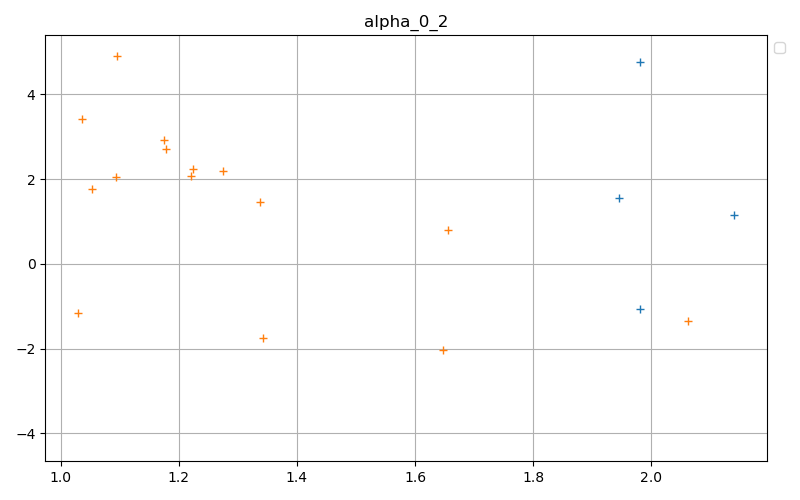

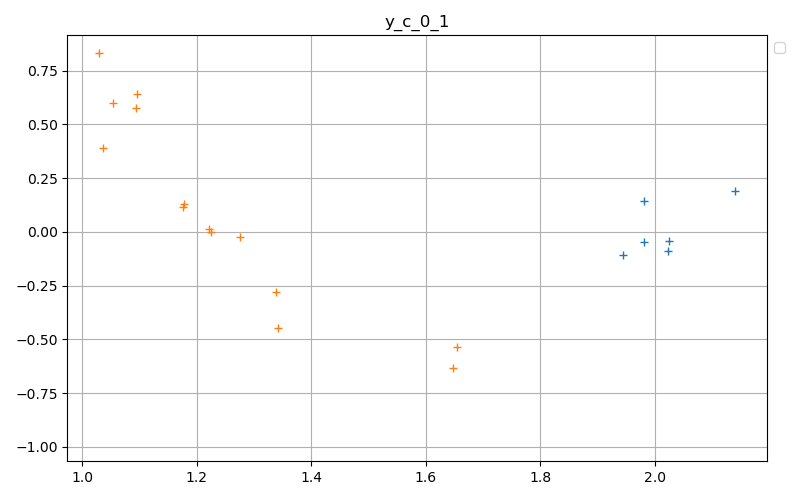

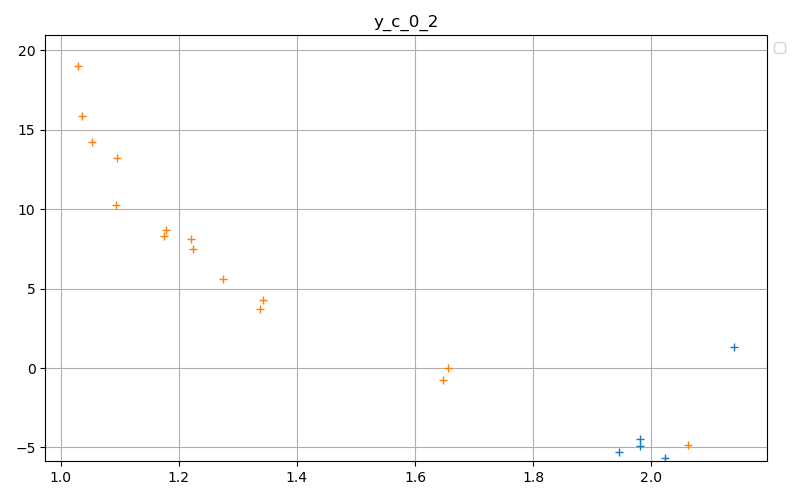

In [143]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()